In [437]:
from pathlib import Path
import re

from eolearn.geometry.transformations import RasterToVector, VectorToRaster
from eolearn.io.local_io import ImportFromTiff
from eolearn.io import VectorImportTask
from eolearn.core import OverwritePermission, FeatureType, EOPatch
# from eolearn.io import ExportToTiff
import sentinelhub

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [438]:
# Source: https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return LinearSegmentedColormap.from_list(cmap_name, color_list, N)

In [439]:
def get_spectral_mean_min_max(data, axis=0):
    """
    Args:
        data (numpy.array): shape (samples, bands)
        
    Returns (mean, min, max)
    """
    
    return np.nanmean(data, axis=axis), np.nanmin(data, axis=axis), np.nanmax(data, axis=axis)
    

In [440]:
# Band names
b_names = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
b_alias = ['Blue', 'Green', 'Red', 'Red Edge', 'Red Edge 2', 'Red Edge 3', 'NIR', 'Narrow NIR', 'SWIR 1', 'SWIR 2']
b_cwave = [490, 560, 665, 705, 740, 783, 842, 865, 1610, 2190]

In [441]:
base_path = Path('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/')

## Polyphytos

In [442]:
polyphytos_shp = list(base_path.glob('*polyphytos*.shp'))
polyphytos_shp

[PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20211219_polyphytos.shp'),
 PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20200831_polyphytos.shp'),
 PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20210118_polyphytos.shp'),
 PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20211224_polyphytos.shp')]

In [443]:
# Get polyphytos bbox
eop_tiff = ImportFromTiff(feature=(FeatureType.DATA, 'temp'),
                          folder='/home/AOIs/polyphytos/young_research_data/sen2cor/S2B_MSIL2A_20211219T092309_N0301_R093_T34TEK_20211219T120442/RT_Subset_S2B_MSIL2A_20211219T092309_N0301_R093_T34TEK_20211219T120442_resampled.tif')
eop_tiff = eop_tiff.execute()
eop_tiff

EOPatch(
  data: {
    temp: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((569630.0, 4440010.0), (594020.0, 4461860.0)), crs=CRS('32634'))
  timestamp: []
)

#### Import vectors

In [444]:
# initialize eop
eop_polyph = EOPatch()

# Import all vectors
for idx, path in enumerate(polyphytos_shp):
    eop_task = VectorImportTask(feature=(FeatureType.VECTOR_TIMELESS, path.stem),
                                path=str(path),
                                reproject=True)

    eop_task = eop_task.execute(bbox=eop_tiff.bbox)
    eop_polyph = eop_polyph.merge(eop_task)

eop_polyph

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20200831_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs=EPSG:32634)
    20210118_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs=EPSG:32634)
    20211219_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=2, crs=EPSG:32634)
    20211224_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((569630.0, 4440010.0), (594020.0, 4461860.0)), crs=CRS('32634'))
  timestamp: []
)

#### Vector to Raster

In [445]:
# Rasterize vector
for idx, path in enumerate(polyphytos_shp):
    eop_task = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, path.stem),
                         raster_feature=(FeatureType.MASK_TIMELESS, path.stem),
                         values=[0, 1],
                         values_column='class',
#                          no_data_value=no_data_value,
                         raster_dtype=np.uint8,
                         raster_resolution=(10, 10))

    eop_task.execute(eop_polyph)

eop_polyph

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20200831_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20210118_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20211219_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20211224_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20200831_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs=EPSG:32634)
    20210118_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs=EPSG:32634)
    20211219_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=2, crs=EPSG:32634)
    20211224_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((569630.0, 4440010.0), (594020.0, 4461860.0)), crs=CRS('32634'))
  tim

Do a simple visualization to see the classes

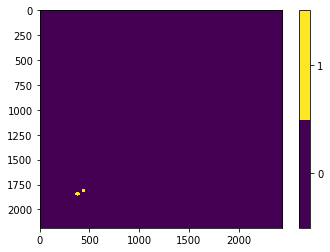

In [446]:
n_classes = np.unique(eop_polyph.mask_timeless['20211219_polyphytos']).size
cmap=discrete_cmap(n_classes, 'viridis')
plt.imshow(eop_polyph.mask_timeless['20211219_polyphytos'].squeeze(), cmap=cmap)
cbar = plt.colorbar(ticks=range(n_classes))
plt.clim(-0.5, n_classes - 0.5)
cbar.ax.set_yticklabels(['0', '1']);  # vertically oriented colorbar

#### Import geotiffs

In [447]:
gtiff_lst = ['/home/AOIs/polyphytos/young_research_data/sen2cor/S2B_MSIL2A_20211219T092309_N0301_R093_T34TEK_20211219T120442/RT_Subset_S2B_MSIL2A_20211219T092309_N0301_R093_T34TEK_20211219T120442_resampled.tif',
             '/home/AOIs/polyphytos/young_research_data/sen2cor/S2A_MSIL2A_20211224T092411_N0301_R093_T34TEK_20211224T124128/RT_Subset_S2A_MSIL2A_20211224T092411_N0301_R093_T34TEK_20211224T124128_resampled.tif',
             '/home/AOIs/polyphytos/young_research_data/sen2cor/S2A_MSIL2A_20210118T092321_N0214_R093_T34TEK_20210118T120704/RT_Subset_S2A_MSIL2A_20210118T092321_N0214_R093_T34TEK_20210118T120704_resampled.tif',
             '/home/AOIs/polyphytos/young_research_data/sen2cor/S2A_MSIL2A_20200831T092031_N0214_R093_T34TEK_20200831T122905/RT_Subset_S2A_MSIL2A_20200831T092031_N0214_R093_T34TEK_20200831T122905_resampled.tif']
gtiff_lst = [Path(i) for i in gtiff_lst]

# Import all Sentinel-2 geotiffs
for idx, path in enumerate(gtiff_lst):
    
    # Read flood geotiff
    eop_task = ImportFromTiff(feature=(FeatureType.DATA, re.findall(r'_([0-9]{8})T[0-9]{6}_', path.stem)[0] + '_polyphytos'),
                           folder=str(path),
                           no_data_value=0)
    
    eop_polyph = eop_polyph.merge(eop_task.execute())

eop_polyph

EOPatch(
  data: {
    20200831_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
    20210118_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
    20211219_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
    20211224_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20200831_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20210118_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20211219_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20211224_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20200831_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs=EPSG:32634)
    20210118_polyphytos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=1, crs

In [448]:
# derive only the pixels that fall on the mask
for fname in eop_polyph.data.keys():
    samples = eop_polyph.data[fname].squeeze()[eop_polyph.mask_timeless[fname].squeeze().astype(np.bool), :]
    eop_polyph.scalar[fname] = samples

eop_polyph

EOPatch(
  data: {
    20200831_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
    20210118_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
    20211219_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
    20211224_polyphytos: numpy.ndarray(shape=(1, 2185, 2439, 10), dtype=float32)
  }
  mask: {}
  scalar: {
    20200831_polyphytos: numpy.ndarray(shape=(1628, 10), dtype=float32)
    20210118_polyphytos: numpy.ndarray(shape=(3292, 10), dtype=float32)
    20211219_polyphytos: numpy.ndarray(shape=(2554, 10), dtype=float32)
    20211224_polyphytos: numpy.ndarray(shape=(2395, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20200831_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20210118_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20211219_polyphytos: numpy.ndarray(shape=(2185, 2439, 1), dtype=uint8)
    20211224_polyphytos: numpy.ndarray(shape=(218

Statistical distributions

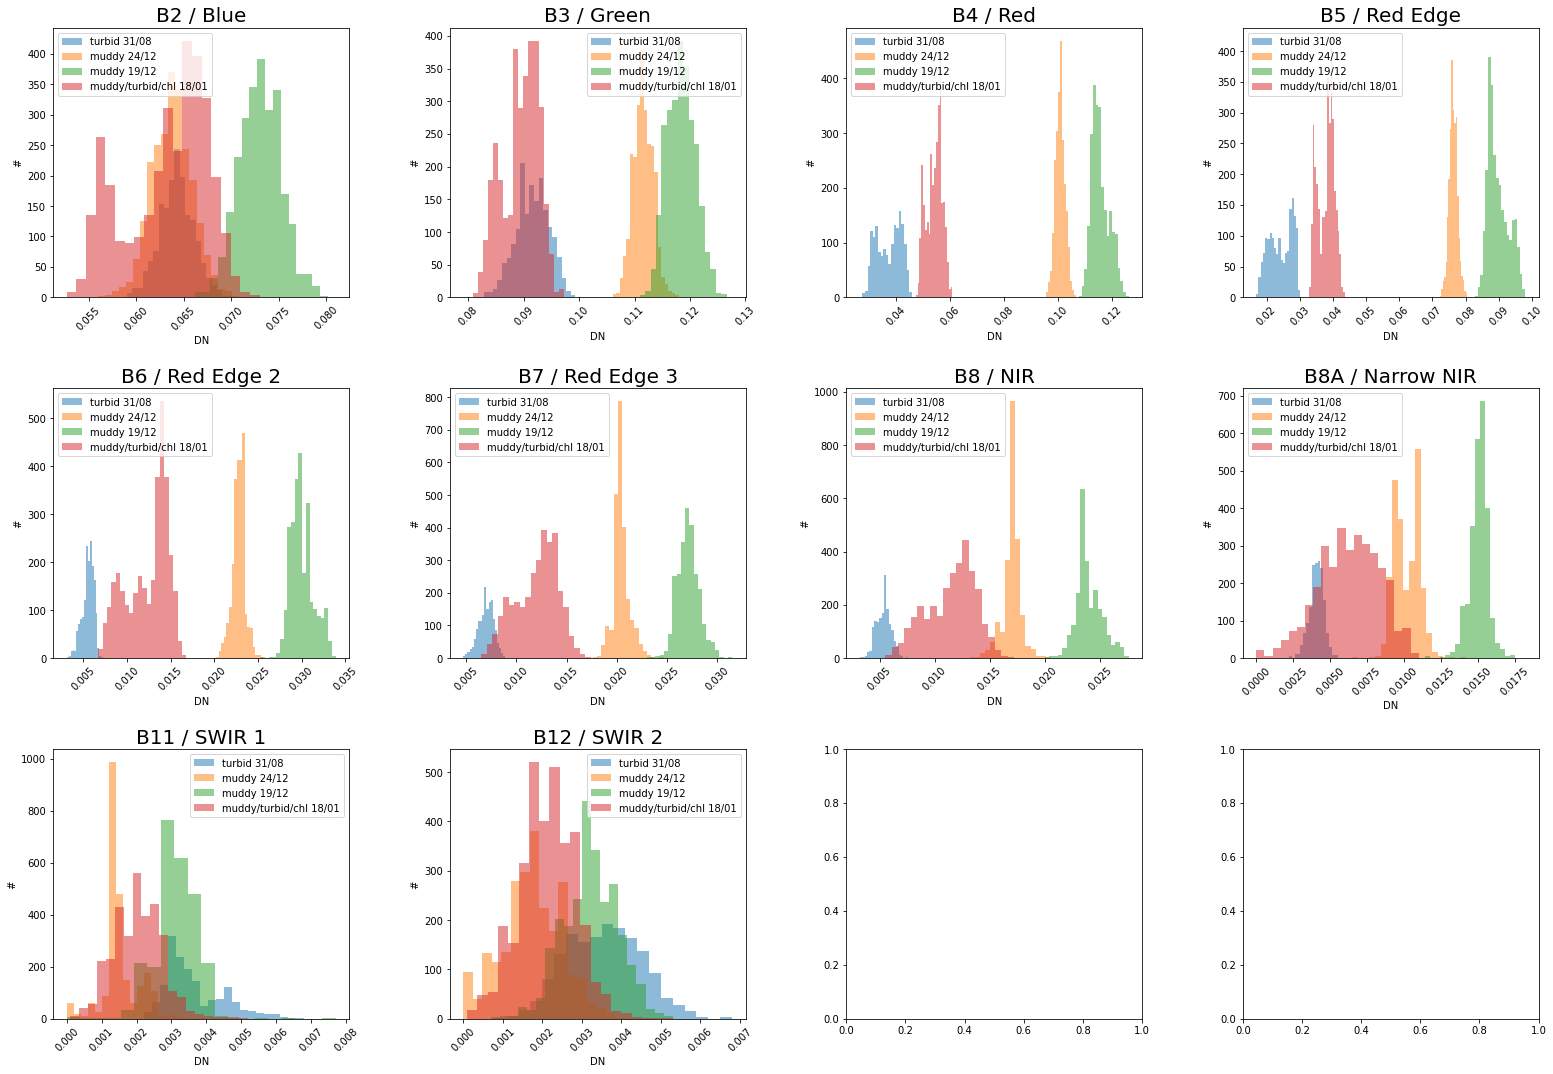

In [449]:
bidx = 2
fig, axes = plt.subplots(figsize=(23, 16), ncols=4, nrows=3)
fig.tight_layout(pad=7.0)
data_keys = eop_polyph.data.keys()

# Construct labels for legend
leg_labels = []
for i in data_keys:
    if '1219' in i:
        leg_labels.append('muddy 19/12')
    elif '1224' in i:
        leg_labels.append('muddy 24/12')
    elif '0831' in i:
        leg_labels.append('turbid 31/08')
    elif '0118' in i:
        leg_labels.append('muddy/turbid/chl 18/01')

# Plot histograms
for fname in data_keys:
    
    for bidx in range(len(b_cwave)):
        
        ax = axes.ravel()[bidx]
        ax.hist(eop_polyph.scalar[fname][:, bidx], bins=20, alpha=0.5);
        ax.set_title(f'{b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
        ax.tick_params('x', rotation=45)
        ax.set_xlabel('DN')
        ax.set_ylabel('#')
        ax.legend(leg_labels, fontsize=10, loc='best');

Spectral signatures

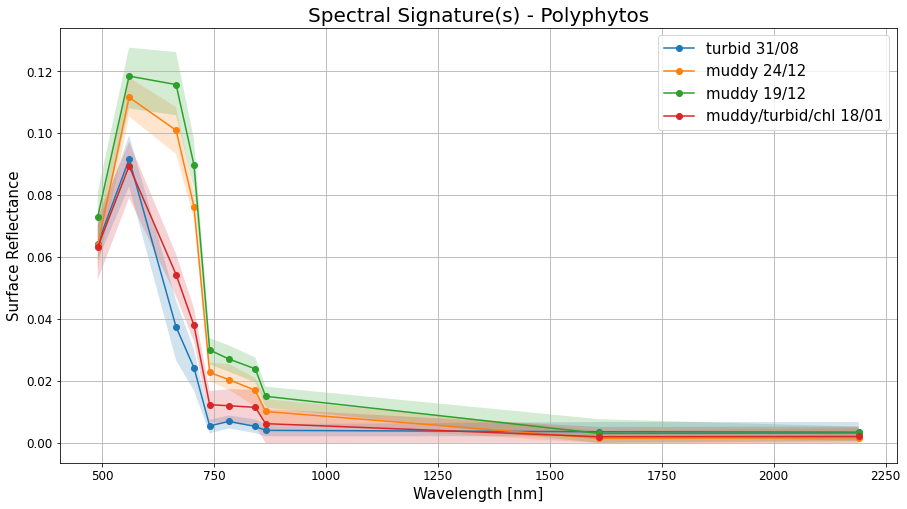

In [450]:
fig, ax = plt.subplots(figsize=(15, 8))

for fname in data_keys:
    
    bmean, bmin, bmax = get_spectral_mean_min_max(eop_polyph.scalar[fname])
    
    ax.fill_between(b_cwave, bmax, bmin, alpha=0.2); # plot confidence intervals
    ax.plot(b_cwave, bmean, '-o'); # plot mean
    
ax.legend(leg_labels, fontsize=15);
ax.set_title('Spectral Signature(s) - Polyphytos', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();


## Giaretta

### Giaretta 1

In [451]:
giaretta_shp = list(base_path.glob('*giaretta.shp'))
giaretta_shp

[PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20181031_giaretta.shp')]

In [452]:
# Get polyphytos bbox
eop_tiff = ImportFromTiff(feature=(FeatureType.DATA, 'temp'),
                          folder='/home/AOIs/polyphytos/young_research_data/sen2cor/from_giaretta/S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939/RT_Subset_S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_resampled.tif')
eop_tiff = eop_tiff.execute()
eop_tiff

EOPatch(
  data: {
    temp: numpy.ndarray(shape=(1, 813, 616, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((708050.0, 5055420.0), (714210.0, 5063550.0)), crs=CRS('32632'))
  timestamp: []
)

#### Import vectors

In [453]:
# initialize eop
eop_giaretta_1 = EOPatch()

# Import all vectors
for idx, path in enumerate(giaretta_shp[:1]):
    eop_task = VectorImportTask(feature=(FeatureType.VECTOR_TIMELESS, path.stem),
                                path=str(path),
                                reproject=True)

#     eop_task = eop_task.execute()
    eop_giaretta_1 = eop_giaretta_1.merge(eop_task.execute(bbox=eop_tiff.bbox))

eop_giaretta_1

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((708050.0, 5055420.0), (714210.0, 5063550.0)), crs=CRS('32632'))
  timestamp: []
)

#### Vector to Raster

In [454]:
# Rasterize vector
for idx, path in enumerate(giaretta_shp):
    eop_task = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, path.stem),
                         raster_feature=(FeatureType.MASK_TIMELESS, path.stem),
                         values=[1, 2, 3],
                         values_column='class',
#                          no_data_value=no_data_value,
                         raster_dtype=np.uint8,
                         raster_resolution=(10, 10))

    eop_task.execute(eop_giaretta_1)

eop_giaretta_1

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta: numpy.ndarray(shape=(813, 616, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((708050.0, 5055420.0), (714210.0, 5063550.0)), crs=CRS('32632'))
  timestamp: []
)

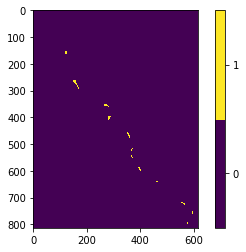

In [455]:
n_classes = np.unique(eop_giaretta_1.mask_timeless['20181031_giaretta']).size
cmap=discrete_cmap(n_classes, 'viridis')
plt.imshow(eop_giaretta_1.mask_timeless['20181031_giaretta'].squeeze(), cmap=cmap)
cbar = plt.colorbar(ticks=range(n_classes))
plt.clim(-0.5, n_classes - 0.5)
cbar.ax.set_yticklabels(['0', '1']);  # vertically oriented colorbar

#### Import geotiffs

In [456]:
gtiff_lst = ['/home/AOIs/polyphytos/young_research_data/sen2cor/from_giaretta/S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939/RT_Subset_S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_resampled.tif']
gtiff_lst = [Path(i) for i in gtiff_lst]

# Import all Sentinel-2 geotiffs
for idx, path in enumerate(gtiff_lst):
    
    # Read flood geotiff
    eop_task = ImportFromTiff(feature=(FeatureType.DATA, re.findall(r'_([0-9]{8})T[0-9]{6}_', path.stem)[0] + '_giaretta'),
                           folder=str(path),
                           no_data_value=0)
    
    eop_giaretta_1 = eop_giaretta_1.merge(eop_task.execute())

eop_giaretta_1

EOPatch(
  data: {
    20181031_giaretta: numpy.ndarray(shape=(1, 813, 616, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta: numpy.ndarray(shape=(813, 616, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((708050.0, 5055420.0), (714210.0, 5063550.0)), crs=CRS('32632'))
  timestamp: []
)

In [457]:
# derive only the pixels that fall on the mask
for fname in eop_giaretta_1.data.keys():
    samples = eop_giaretta_1.data[fname].squeeze()[eop_giaretta_1.mask_timeless[fname].squeeze().astype(np.bool), :]
    eop_giaretta_1.scalar[fname] = samples

eop_giaretta_1

EOPatch(
  data: {
    20181031_giaretta: numpy.ndarray(shape=(1, 813, 616, 10), dtype=float32)
  }
  mask: {}
  scalar: {
    20181031_giaretta: numpy.ndarray(shape=(1070, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta: numpy.ndarray(shape=(813, 616, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((708050.0, 5055420.0), (714210.0, 5063550.0)), crs=CRS('32632'))
  timestamp: []
)

Statistical Distributions

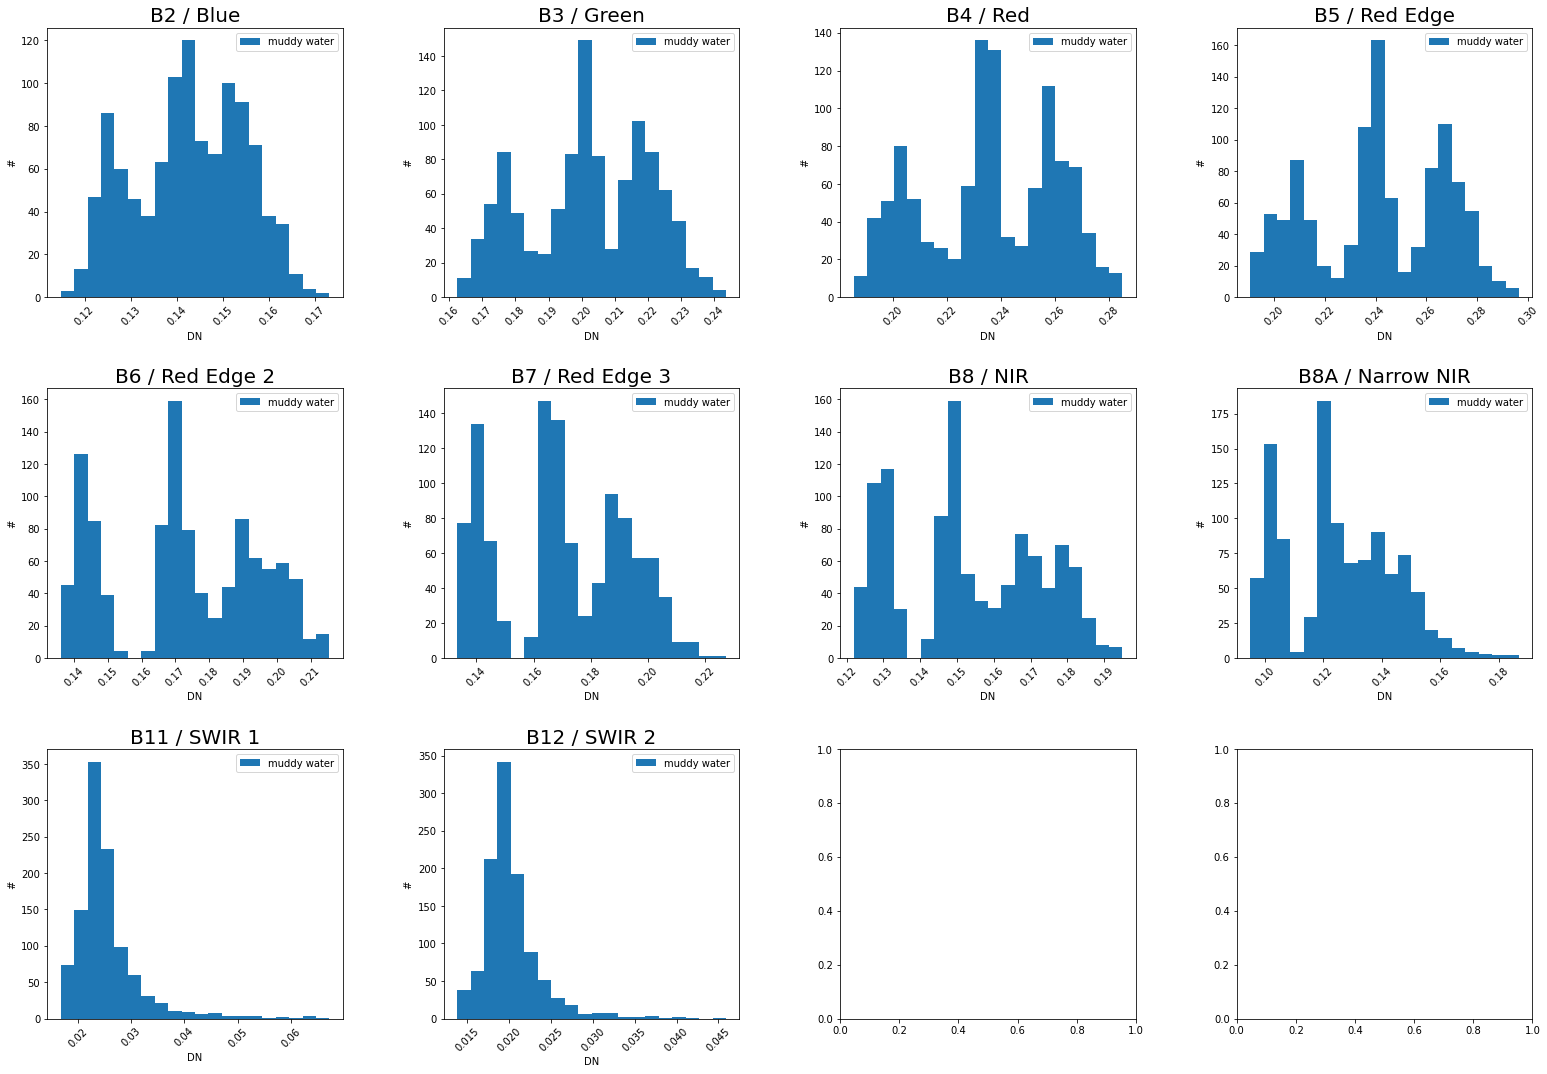

In [458]:
fig, axes = plt.subplots(figsize=(23, 16), ncols=4, nrows=3)
fig.tight_layout(pad=7.0)

# Plot histograms
for bidx in range(len(b_cwave)):

    ax = axes.ravel()[bidx]
    ax.hist(eop_giaretta_1.scalar['20181031_giaretta'][:, bidx], bins=20);
    ax.set_title(f'{b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
    ax.tick_params('x', rotation=45)
    ax.set_xlabel('DN')
    ax.set_ylabel('#')
    ax.legend(['muddy water'], fontsize=10, loc='best');

Spectral signatures

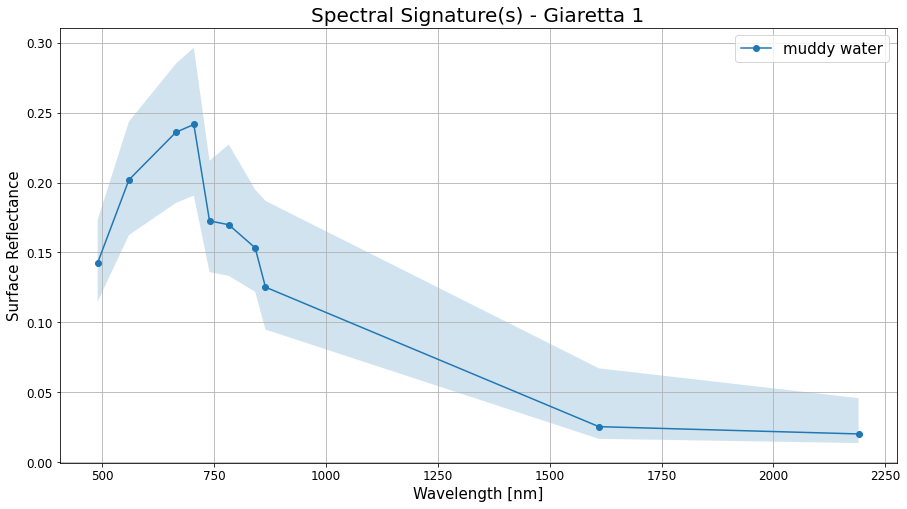

In [459]:
fig, ax = plt.subplots(figsize=(15, 8))


bmean, bmin, bmax = get_spectral_mean_min_max(eop_giaretta_1.scalar['20181031_giaretta'])

ax.fill_between(b_cwave, bmax, bmin, alpha=0.2); # plot confidence intervals
ax.plot(b_cwave, bmean, '-o'); # plot mean
    
ax.legend(['muddy water'], fontsize=15);
ax.set_title('Spectral Signature(s) - Giaretta 1', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();

### Giaretta 2

In [460]:
giaretta_shp = list(base_path.glob('*giaretta_2.shp'))
giaretta_shp

[PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20181031_giaretta_2.shp')]

In [461]:
# Get polyphytos bbox
eop_tiff = ImportFromTiff(feature=(FeatureType.DATA, 'temp'),
                          folder='/home/AOIs/polyphytos/young_research_data/sen2cor/from_giaretta/S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_2/RT_Subset_S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_resampled_2.tif')
eop_tiff = eop_tiff.execute()
eop_tiff

EOPatch(
  data: {
    temp: numpy.ndarray(shape=(1, 3286, 4236, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((744000.0, 4992140.0), (786360.0, 5025000.0)), crs=CRS('32632'))
  timestamp: []
)

#### Import vectors

In [462]:
# initialize eop
eop_giaretta_2 = EOPatch()

# Import all vectors
for idx, path in enumerate(giaretta_shp):
    eop_task = VectorImportTask(feature=(FeatureType.VECTOR_TIMELESS, path.stem),
                                path=str(path),
                                reproject=True)

#     eop_task = eop_task.execute()
    eop_giaretta_2 = eop_giaretta_2.merge(eop_task.execute(bbox=eop_tiff.bbox))

eop_giaretta_2

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_2: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((744000.0, 4992140.0), (786360.0, 5025000.0)), crs=CRS('32632'))
  timestamp: []
)

#### Vector to Raster

In [463]:
# Rasterize vector
for idx, path in enumerate(giaretta_shp):
    eop_task = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, path.stem),
                         raster_feature=(FeatureType.MASK_TIMELESS, path.stem),
                         values=[1, 2, 3],
                         values_column='class',
#                          no_data_value=no_data_value,
                         raster_dtype=np.uint8,
                         raster_resolution=(10, 10))

    eop_task.execute(eop_giaretta_2)

eop_giaretta_2

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta_2: numpy.ndarray(shape=(3286, 4236, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_2: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((744000.0, 4992140.0), (786360.0, 5025000.0)), crs=CRS('32632'))
  timestamp: []
)

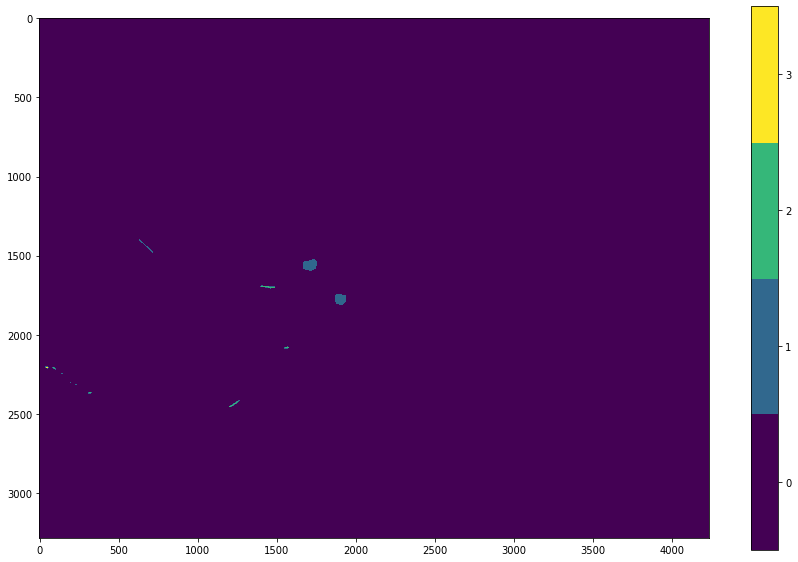

In [464]:
n_classes = np.unique(eop_giaretta_2.mask_timeless['20181031_giaretta_2']).size
cmap=discrete_cmap(n_classes, 'viridis')
plt.figure(figsize=(15, 10))
plt.imshow(eop_giaretta_2.mask_timeless['20181031_giaretta_2'].squeeze(), cmap=cmap)
cbar = plt.colorbar(ticks=range(n_classes))
plt.clim(-0.5, n_classes - 0.5)
cbar.ax.set_yticklabels(['0', '1', '2', '3']);  # vertically oriented colorbar

In [465]:
n_classes

4

#### Import geotiffs

In [466]:
gtiff_lst = ['/home/AOIs/polyphytos/young_research_data/sen2cor/from_giaretta/S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_2/RT_Subset_S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_resampled_2.tif']
gtiff_lst = [Path(i) for i in gtiff_lst]

# Import all Sentinel-2 geotiffs
for idx, path in enumerate(gtiff_lst):
    
    # Read flood geotiff
    eop_task = ImportFromTiff(feature=(FeatureType.DATA, re.findall(r'_([0-9]{8})T[0-9]{6}_', path.stem)[0] + '_giaretta_2'),
                           folder=str(path),
                           no_data_value=0)
    
    eop_giaretta_2 = eop_giaretta_2.merge(eop_task.execute())

eop_giaretta_2

EOPatch(
  data: {
    20181031_giaretta_2: numpy.ndarray(shape=(1, 3286, 4236, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta_2: numpy.ndarray(shape=(3286, 4236, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_2: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((744000.0, 4992140.0), (786360.0, 5025000.0)), crs=CRS('32632'))
  timestamp: []
)

In [467]:
# derive only the pixels that fall on the mask
fname = '20181031_giaretta_2'
for feat_name in [('muddy_coast', 1), ('muddy_river', 2), ('muddy_river_cloud', 3)]:
    eop_giaretta_2.scalar[feat_name[0]] = eop_giaretta_2.data[fname].squeeze()[eop_giaretta_2.mask_timeless[fname].squeeze()==feat_name[1], :]

eop_giaretta_2

EOPatch(
  data: {
    20181031_giaretta_2: numpy.ndarray(shape=(1, 3286, 4236, 10), dtype=float32)
  }
  mask: {}
  scalar: {
    muddy_coast: numpy.ndarray(shape=(9310, 10), dtype=float32)
    muddy_river: numpy.ndarray(shape=(2543, 10), dtype=float32)
    muddy_river_cloud: numpy.ndarray(shape=(376, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta_2: numpy.ndarray(shape=(3286, 4236, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_2: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=12, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((744000.0, 4992140.0), (786360.0, 5025000.0)), crs=CRS('32632'))
  timestamp: []
)

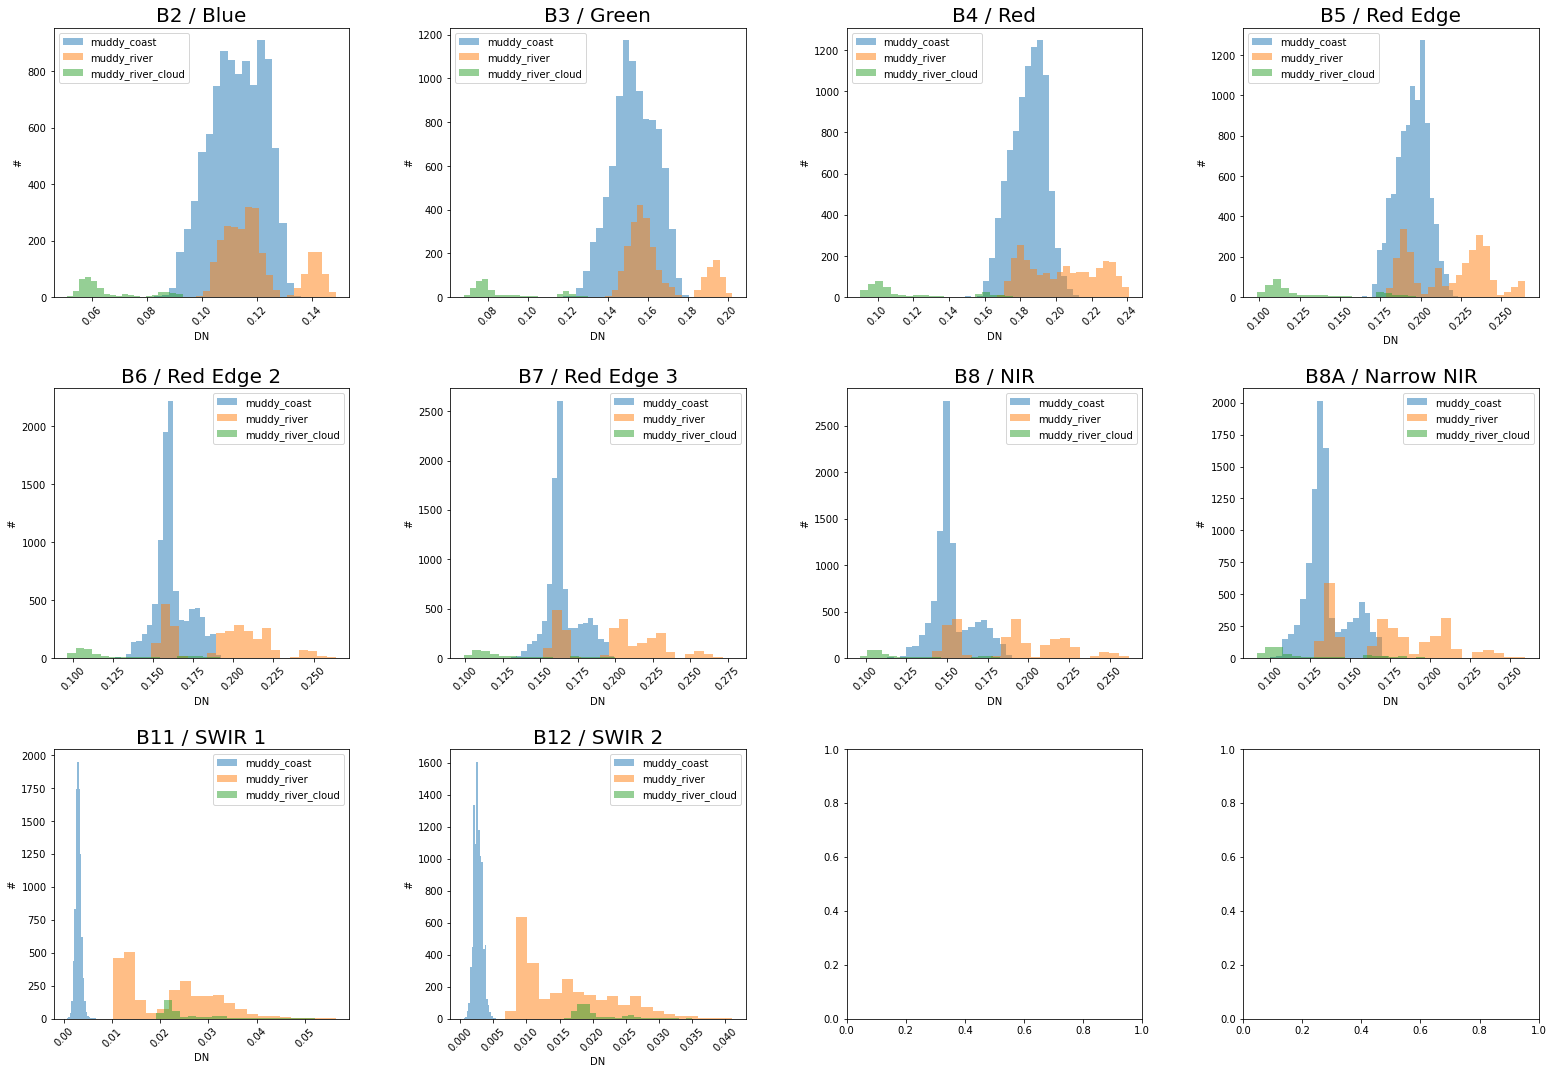

In [468]:
# bidx = 2
fig, axes = plt.subplots(figsize=(23, 16), ncols=4, nrows=3)
fig.tight_layout(pad=7.0)
data_keys = eop_giaretta_2.scalar.keys()

# Plot histograms
for fname in data_keys:
    
    for bidx in range(len(b_cwave)):
        
        ax = axes.ravel()[bidx]
        ax.hist(eop_giaretta_2.scalar[fname][:, bidx], bins=20, alpha=0.5);
        ax.set_title(f'{b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
        ax.tick_params('x', rotation=45)
        ax.set_xlabel('DN')
        ax.set_ylabel('#')
        ax.legend(data_keys, fontsize=10, loc='best');

Spectral signatures

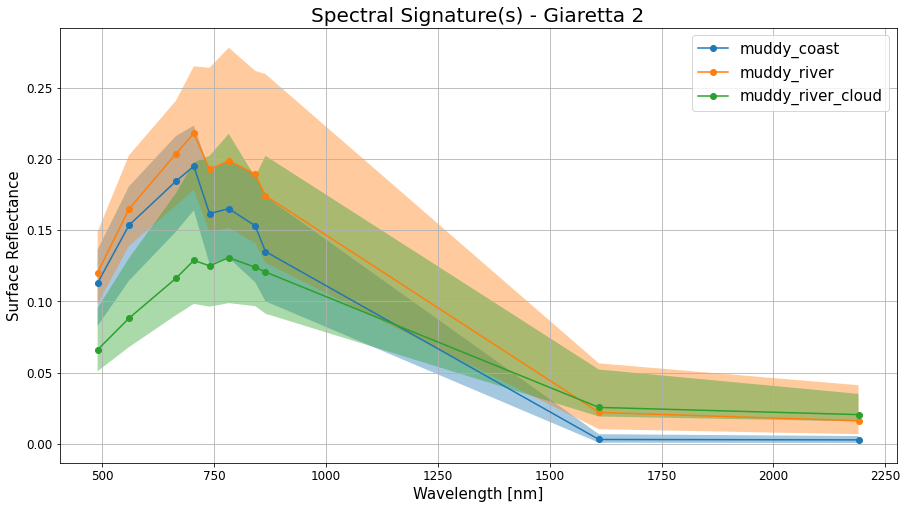

In [469]:
fig, ax = plt.subplots(figsize=(15, 8))

for fname in data_keys:
    
    bmean, bmin, bmax = get_spectral_mean_min_max(eop_giaretta_2.scalar[fname])
    
    ax.fill_between(b_cwave, bmax, bmin, alpha=0.4); # plot confidence intervals
    ax.plot(b_cwave, bmean, '-o'); # plot mean
    
ax.legend(data_keys, fontsize=15);
ax.set_title('Spectral Signature(s) - Giaretta 2', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();

### Giaretta 3

In [470]:
giaretta_shp = list(base_path.glob('*giaretta_3.shp'))
giaretta_shp

[PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20181031_giaretta_3.shp')]

In [471]:
# Get polyphytos bbox
eop_tiff = ImportFromTiff(feature=(FeatureType.DATA, 'temp'),
                          folder='/home/AOIs/polyphytos/young_research_data/sen2cor/from_giaretta/S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_3/RT_Subset_S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_resampled_3.tif')
eop_tiff = eop_tiff.execute()
eop_tiff

EOPatch(
  data: {
    temp: numpy.ndarray(shape=(1, 4960, 4420, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((761640.0, 5027460.0), (805840.0, 5077060.0)), crs=CRS('32632'))
  timestamp: []
)

#### Import vectors

In [472]:
# initialize eop
eop_giaretta_3 = EOPatch()

# Import all vectors
for idx, path in enumerate(giaretta_shp):
    eop_task = VectorImportTask(feature=(FeatureType.VECTOR_TIMELESS, path.stem),
                                path=str(path),
                                reproject=True)

#     eop_task = eop_task.execute()
    eop_giaretta_3 = eop_giaretta_3.merge(eop_task.execute(bbox=eop_tiff.bbox))

eop_giaretta_3

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_3: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=22, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((761640.0, 5027460.0), (805840.0, 5077060.0)), crs=CRS('32632'))
  timestamp: []
)

#### Vector to Raster

In [473]:
# Rasterize vector
for idx, path in enumerate(giaretta_shp):
    eop_task = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, path.stem),
                         raster_feature=(FeatureType.MASK_TIMELESS, path.stem),
                         values=[1, 2, 3, 4],
                         values_column='class',
#                          no_data_value=no_data_value,
                         raster_dtype=np.uint8,
                         raster_resolution=(10, 10))

    eop_task.execute(eop_giaretta_3)

eop_giaretta_3

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta_3: numpy.ndarray(shape=(4960, 4420, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_3: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=22, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((761640.0, 5027460.0), (805840.0, 5077060.0)), crs=CRS('32632'))
  timestamp: []
)

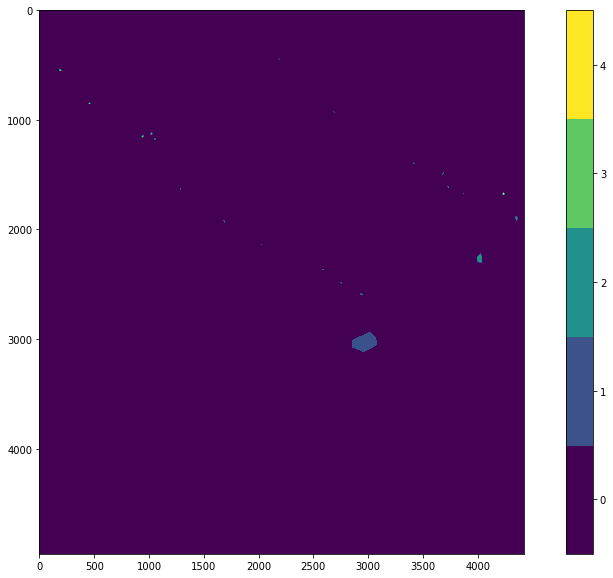

In [474]:
n_classes = np.unique(eop_giaretta_3.mask_timeless['20181031_giaretta_3']).size
cmap=discrete_cmap(n_classes, 'viridis')
plt.figure(figsize=(15, 10))
plt.imshow(eop_giaretta_3.mask_timeless['20181031_giaretta_3'].squeeze(), cmap=cmap)
cbar = plt.colorbar(ticks=range(n_classes))
plt.clim(-0.5, n_classes - 0.5)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4']);  # vertically oriented colorbar

In [475]:
n_classes

5

#### Import geotiffs

In [476]:
gtiff_lst = ['/home/AOIs/polyphytos/young_research_data/sen2cor/from_giaretta/S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_3/RT_Subset_S2B_MSIL2A_20181031T101139_N0209_R022_T32TQR_20181031T131939_resampled_3.tif']
gtiff_lst = [Path(i) for i in gtiff_lst]

# Import all Sentinel-2 geotiffs
for idx, path in enumerate(gtiff_lst):
    
    # Read flood geotiff
    eop_task = ImportFromTiff(feature=(FeatureType.DATA, re.findall(r'_([0-9]{8})T[0-9]{6}_', path.stem)[0] + '_giaretta_3'),
                           folder=str(path),
                           no_data_value=0)
    
    eop_giaretta_3 = eop_giaretta_3.merge(eop_task.execute())

eop_giaretta_3

EOPatch(
  data: {
    20181031_giaretta_3: numpy.ndarray(shape=(1, 4960, 4420, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta_3: numpy.ndarray(shape=(4960, 4420, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_3: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=22, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((761640.0, 5027460.0), (805840.0, 5077060.0)), crs=CRS('32632'))
  timestamp: []
)

In [477]:
# derive only the pixels that fall on the mask
fname = '20181031_giaretta_3'
for feat_name in [('muddy_coast_left', 1), ('muddy_coast_right', 2), ('muddy_river_left', 3), ('muddy_river_right', 4)]:
    eop_giaretta_3.scalar[feat_name[0]] = eop_giaretta_3.data[fname].squeeze()[eop_giaretta_3.mask_timeless[fname].squeeze()==feat_name[1], :]

eop_giaretta_3

EOPatch(
  data: {
    20181031_giaretta_3: numpy.ndarray(shape=(1, 4960, 4420, 10), dtype=float32)
  }
  mask: {}
  scalar: {
    muddy_coast_left: numpy.ndarray(shape=(27953, 10), dtype=float32)
    muddy_coast_right: numpy.ndarray(shape=(3554, 10), dtype=float32)
    muddy_river_left: numpy.ndarray(shape=(1642, 10), dtype=float32)
    muddy_river_right: numpy.ndarray(shape=(652, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20181031_giaretta_3: numpy.ndarray(shape=(4960, 4420, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20181031_giaretta_3: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=22, crs=EPSG:32632)
  }
  meta_info: {}
  bbox: BBox(((761640.0, 5027460.0), (805840.0, 5077060.0)), crs=CRS('32632'))
  timestamp: []
)

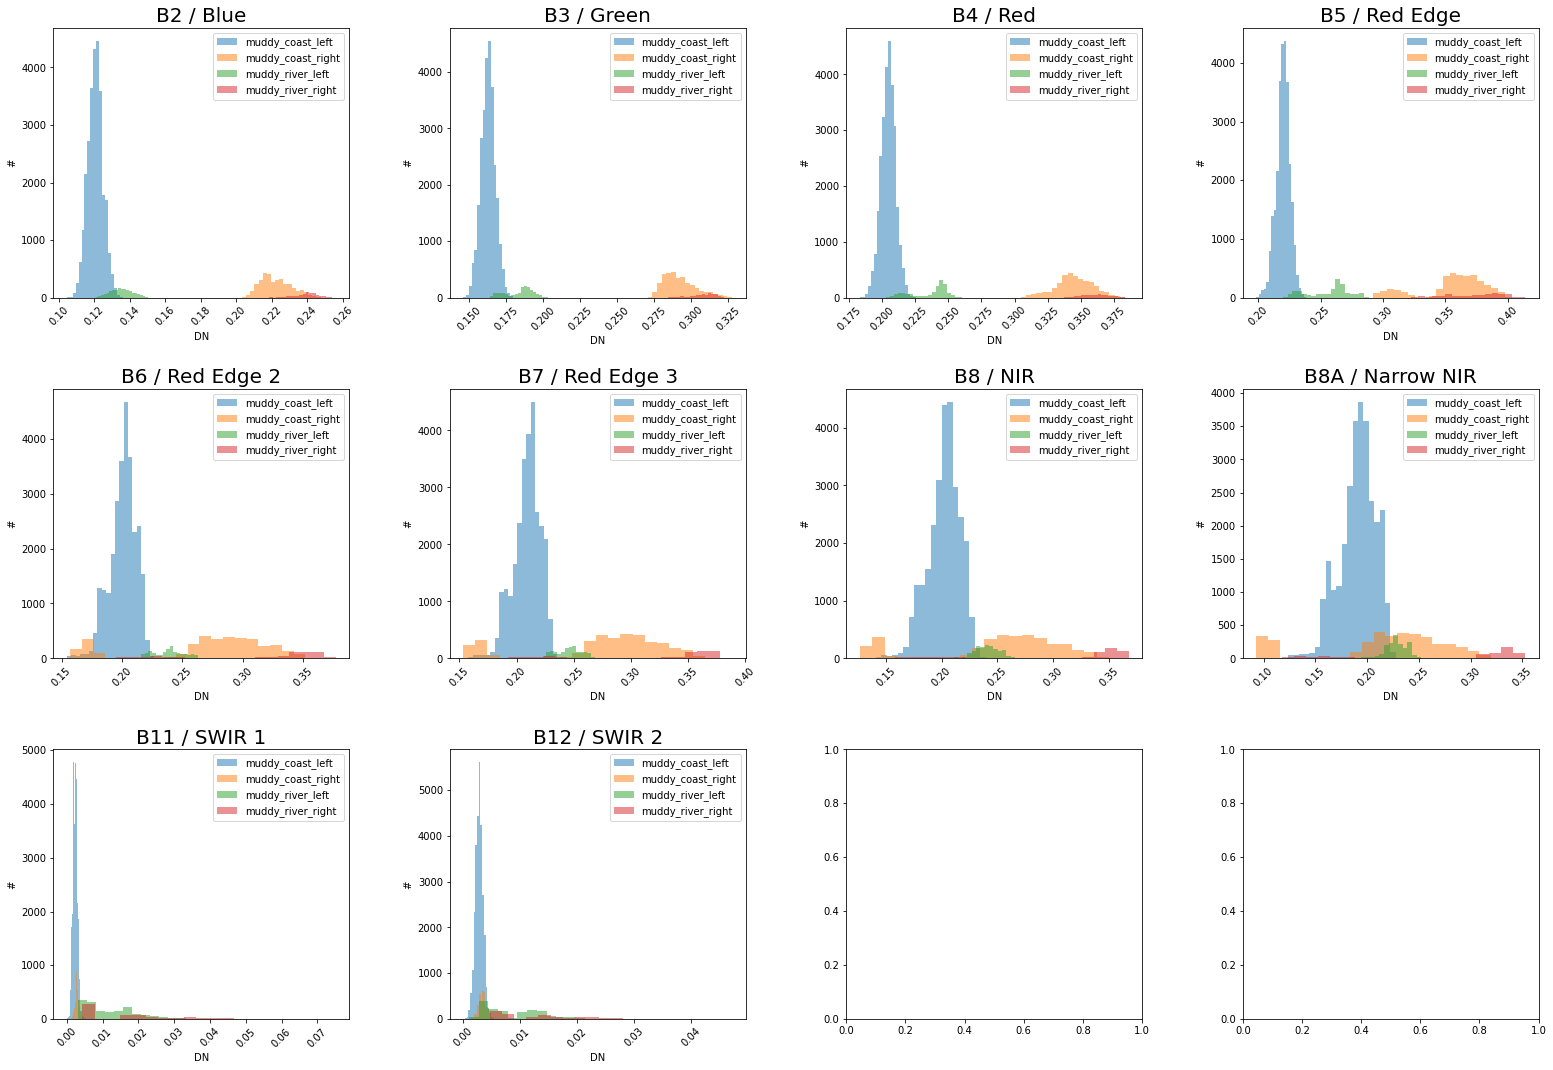

In [478]:
fig, axes = plt.subplots(figsize=(23, 16), ncols=4, nrows=3)
fig.tight_layout(pad=7.0)
data_keys = eop_giaretta_3.scalar.keys()

# Plot histograms
for fname in data_keys:
    
    for bidx in range(len(b_cwave)):
        
        ax = axes.ravel()[bidx]
        ax.hist(eop_giaretta_3.scalar[fname][:, bidx], bins=20, alpha=0.5);
        ax.set_title(f'{b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
        ax.tick_params('x', rotation=45)
        ax.set_xlabel('DN')
        ax.set_ylabel('#')
        ax.legend(data_keys, fontsize=10, loc='best');

Spectral signatures

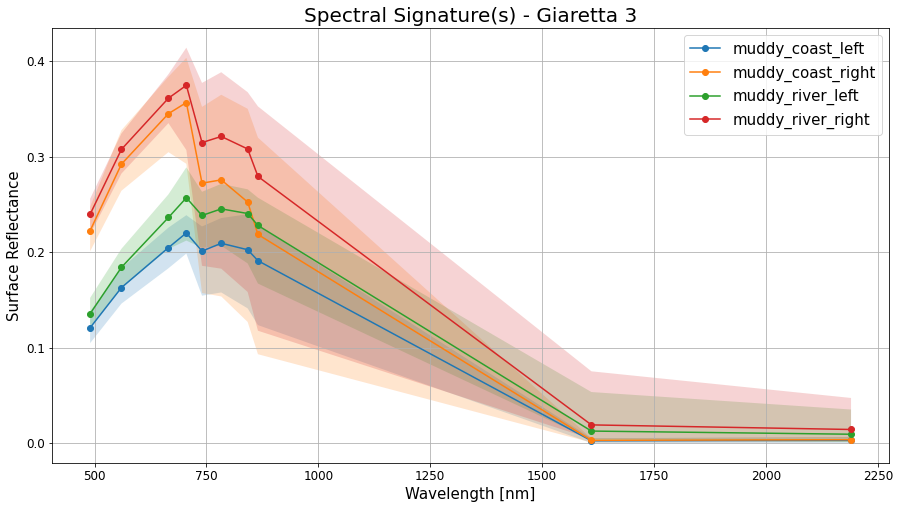

In [479]:
fig, ax = plt.subplots(figsize=(15, 8))

for fname in data_keys:
    
    bmean, bmin, bmax = get_spectral_mean_min_max(eop_giaretta_3.scalar[fname])
    
    ax.fill_between(b_cwave, bmax, bmin, alpha=0.2); # plot confidence intervals
    ax.plot(b_cwave, bmean, '-o'); # plot mean
    
ax.legend(data_keys, fontsize=15);
ax.set_title('Spectral Signature(s) - Giaretta 3', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();

### Pori

In [480]:
pori_shp = list(base_path.glob('*pori.shp'))
pori_shp

[PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20210420_pori.shp')]

In [481]:
# Get polyphytos bbox
eop_tiff = ImportFromTiff(feature=(FeatureType.DATA, 'temp'),
                          folder='/home/AOIs/polyphytos/young_research_data/sen2cor/from_miscellaneous/pori/RT_Subset_S2A_MSIL2A_20210420T100021_N0300_R122_T34VEP_20210420T114413_resampled.tif')
eop_tiff = eop_tiff.execute()
eop_tiff

EOPatch(
  data: {
    temp: numpy.ndarray(shape=(1, 6745, 5021, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((503840.0, 6801450.0), (554050.0, 6868900.0)), crs=CRS('32634'))
  timestamp: []
)

#### Import vectors

In [482]:
# initialize eop
eop_pori = EOPatch()

# Import all vectors
for idx, path in enumerate(pori_shp):
    eop_task = VectorImportTask(feature=(FeatureType.VECTOR_TIMELESS, path.stem),
                                path=str(path),
                                reproject=True)

#     eop_task = eop_task.execute()
    eop_pori = eop_pori.merge(eop_task.execute(bbox=eop_tiff.bbox))

eop_pori

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_pori: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=26, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((503840.0, 6801450.0), (554050.0, 6868900.0)), crs=CRS('32634'))
  timestamp: []
)

#### Vector to Raster

In [483]:
# Rasterize vector
for idx, path in enumerate(pori_shp):
    eop_task = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, path.stem),
                         raster_feature=(FeatureType.MASK_TIMELESS, path.stem),
                         values=[1, 2, 3, 4, 5, 6, 7],
                         values_column='class',
#                          no_data_value=no_data_value,
                         raster_dtype=np.uint8,
                         raster_resolution=(10, 10))

    eop_task.execute(eop_pori)

eop_pori

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20210420_pori: numpy.ndarray(shape=(6745, 5021, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_pori: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=26, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((503840.0, 6801450.0), (554050.0, 6868900.0)), crs=CRS('32634'))
  timestamp: []
)

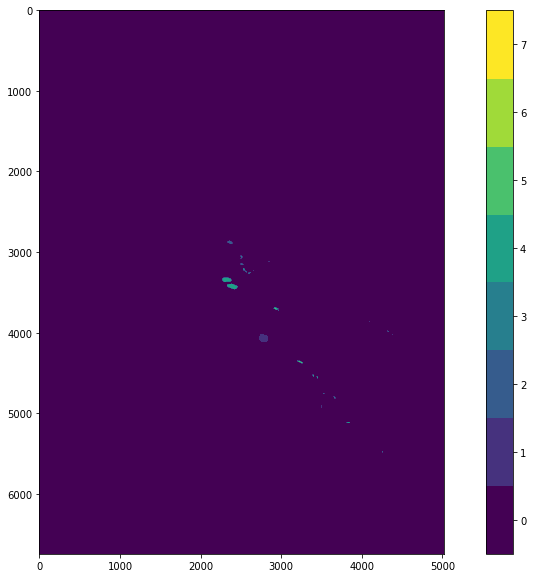

In [484]:
n_classes = np.unique(eop_pori.mask_timeless['20210420_pori']).size
cmap=discrete_cmap(n_classes, 'viridis')
plt.figure(figsize=(15, 10))
plt.imshow(eop_pori.mask_timeless['20210420_pori'].squeeze(), cmap=cmap)
cbar = plt.colorbar(ticks=range(n_classes))
plt.clim(-0.5, n_classes - 0.5)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6', '7']);  # vertically oriented colorbar

In [485]:
n_classes

8

#### Import geotiffs

In [486]:
gtiff_lst = ['/home/AOIs/polyphytos/young_research_data/sen2cor/from_miscellaneous/pori/RT_Subset_S2A_MSIL2A_20210420T100021_N0300_R122_T34VEP_20210420T114413_resampled.tif']
gtiff_lst = [Path(i) for i in gtiff_lst]

# Import all Sentinel-2 geotiffs
for idx, path in enumerate(gtiff_lst):
    
    # Read flood geotiff
    eop_task = ImportFromTiff(feature=(FeatureType.DATA, re.findall(r'_([0-9]{8})T[0-9]{6}_', path.stem)[0] + '_pori'),
                           folder=str(path),
                           no_data_value=0)
    
    eop_pori = eop_pori.merge(eop_task.execute())

eop_pori

EOPatch(
  data: {
    20210420_pori: numpy.ndarray(shape=(1, 6745, 5021, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20210420_pori: numpy.ndarray(shape=(6745, 5021, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_pori: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=26, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((503840.0, 6801450.0), (554050.0, 6868900.0)), crs=CRS('32634'))
  timestamp: []
)

In [487]:
# derive only the pixels that fall on the mask
fname = '20210420_pori'
for feat_name in [('muddy_coast_mid_brown', 1), ('muddy_coast_dark_brown', 2), ('muddy_coast_very_dark_brown', 3), ('muddy_coast_light_brown', 4),
                  ('muddy_coast_outlier_brown', 5), ('muddy_river_very_dark_brown', 6), ('muddy_river_dark_brown', 7)]:
    eop_pori.scalar[feat_name[0]] = eop_pori.data[fname].squeeze()[eop_pori.mask_timeless[fname].squeeze()==feat_name[1], :]

eop_pori

EOPatch(
  data: {
    20210420_pori: numpy.ndarray(shape=(1, 6745, 5021, 10), dtype=float32)
  }
  mask: {}
  scalar: {
    muddy_coast_dark_brown: numpy.ndarray(shape=(2876, 10), dtype=float32)
    muddy_coast_light_brown: numpy.ndarray(shape=(11400, 10), dtype=float32)
    muddy_coast_mid_brown: numpy.ndarray(shape=(9456, 10), dtype=float32)
    muddy_coast_outlier_brown: numpy.ndarray(shape=(1129, 10), dtype=float32)
    muddy_coast_very_dark_brown: numpy.ndarray(shape=(2037, 10), dtype=float32)
    muddy_river_dark_brown: numpy.ndarray(shape=(1799, 10), dtype=float32)
    muddy_river_very_dark_brown: numpy.ndarray(shape=(312, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20210420_pori: numpy.ndarray(shape=(6745, 5021, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_pori: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=26, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((5

In [488]:
# bidx = 2
# fig, ax = plt.subplots(figsize=(15, 8))
# plt.hist(eop_pori.scalar['muddy_coast_mid_brown'][:, bidx], bins=25);
# plt.hist(eop_pori.scalar['muddy_coast_dark_brown'][:, bidx], bins=25);
# plt.hist(eop_pori.scalar['muddy_coast_very_dark_brown'][:, bidx], bins=25);
# plt.hist(eop_pori.scalar['muddy_coast_light_brown'][:, bidx], bins=25);
# plt.hist(eop_pori.scalar['muddy_coast_outlier_brown'][:, bidx], bins=25);
# plt.hist(eop_pori.scalar['muddy_river_very_dark_brown'][:, bidx], bins=25);
# plt.hist(eop_pori.scalar['muddy_river_dark_brown'][:, bidx], bins=25, alpha=0.55);
# plt.title(f'Pori - {b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
# plt.xlabel('DN', fontsize=15)
# plt.ylabel('# Observations', fontsize=15);
# plt.legend(['muddy coast mid brown', 'muddy coast dark brown', 'muddy coast very dark brown',
#             'muddy coast light brown', 'muddy coast outlier brown', 'muddy river very dark brown', 'muddy river dark brown'], fontsize=15);

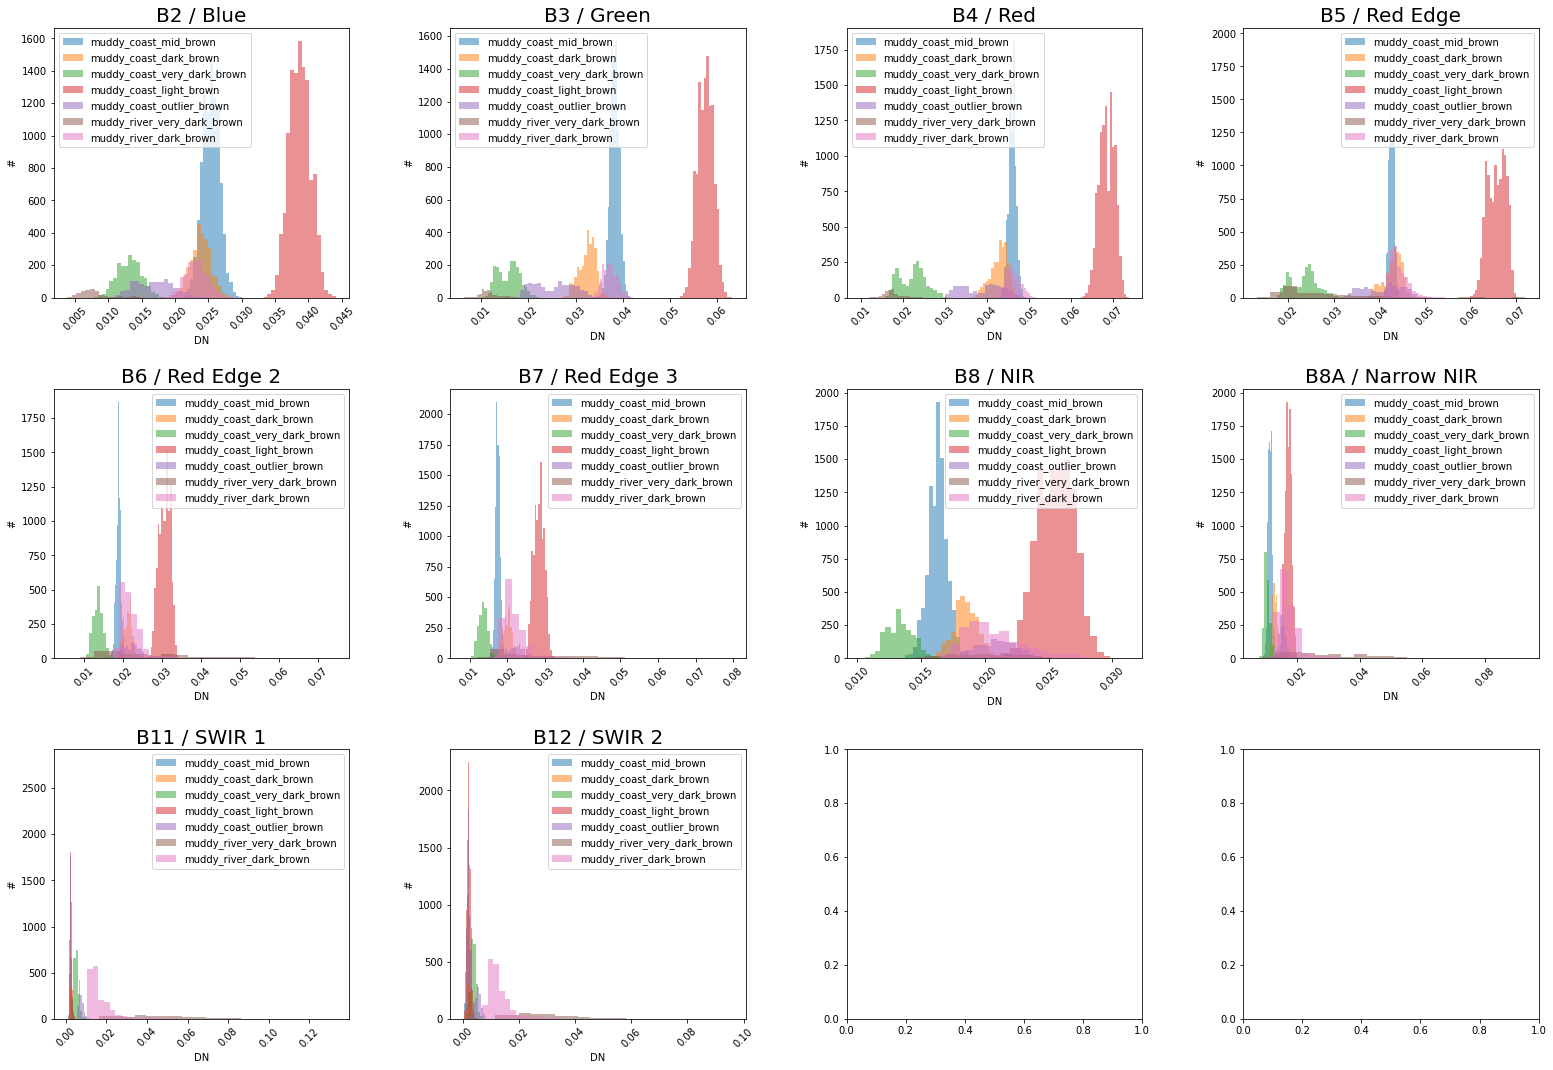

In [489]:
fig, axes = plt.subplots(figsize=(23, 16), ncols=4, nrows=3)
fig.tight_layout(pad=7.0)
data_keys = eop_pori.scalar.keys()

# Plot histograms
for fname in data_keys:
    
    for bidx in range(len(b_cwave)):
        
        ax = axes.ravel()[bidx]
        ax.hist(eop_pori.scalar[fname][:, bidx], bins=20, alpha=0.5);
        ax.set_title(f'{b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
        ax.tick_params('x', rotation=45)
        ax.set_xlabel('DN')
        ax.set_ylabel('#')
        ax.legend(data_keys, fontsize=10, loc='best');

Spectral signatures

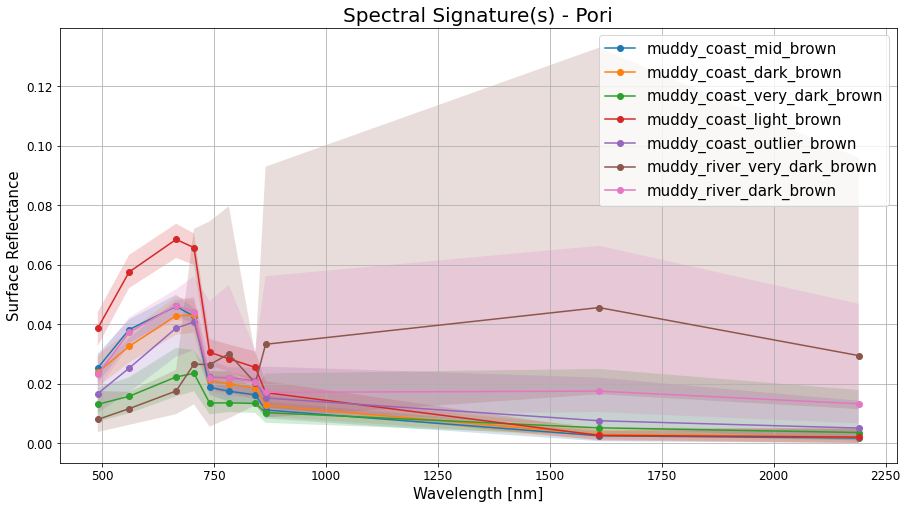

In [490]:
fig, ax = plt.subplots(figsize=(15, 8))

for fname in data_keys:
    
    bmean, bmin, bmax = get_spectral_mean_min_max(eop_pori.scalar[fname])
    
    ax.fill_between(b_cwave, bmax, bmin, alpha=0.2); # plot confidence intervals
    ax.plot(b_cwave, bmean, '-o'); # plot mean
    
ax.legend(data_keys, fontsize=15);
ax.set_title('Spectral Signature(s) - Pori', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();

### Salo

In [491]:
salo_shp = list(base_path.glob('*salo.shp'))
salo_shp

[PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20210420_salo.shp')]

In [492]:
# Get polyphytos bbox
eop_tiff = ImportFromTiff(feature=(FeatureType.DATA, 'temp'),
                          folder='/home/AOIs/polyphytos/young_research_data/sen2cor/from_miscellaneous/salo/RT_Subset_S2A_MSIL2A_20210420T100021_N0300_R122_T34VEM_20210420T114413_resampled.tif')
eop_tiff = eop_tiff.execute()
eop_tiff

EOPatch(
  data: {
    temp: numpy.ndarray(shape=(1, 2564, 3158, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: []
)

#### Import vectors

In [493]:
# initialize eop
eop_salo = EOPatch()

# Import all vectors
for idx, path in enumerate(salo_shp):
    eop_task = VectorImportTask(feature=(FeatureType.VECTOR_TIMELESS, path.stem),
                                path=str(path),
                                reproject=True)

#     eop_task = eop_task.execute()
    eop_salo = eop_salo.merge(eop_task.execute(bbox=eop_tiff.bbox))

eop_salo

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_salo: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=11, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: []
)

#### Vector to Raster

In [494]:
# Rasterize vector
for idx, path in enumerate(salo_shp):
    eop_task = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, path.stem),
                         raster_feature=(FeatureType.MASK_TIMELESS, path.stem),
                         values=[1, 2, 3, 4, 5, 6],
                         values_column='class',
#                          no_data_value=no_data_value,
                         raster_dtype=np.uint8,
                         raster_resolution=(10, 10))

    eop_task.execute(eop_salo)

eop_salo

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20210420_salo: numpy.ndarray(shape=(2564, 3158, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_salo: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=11, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: []
)

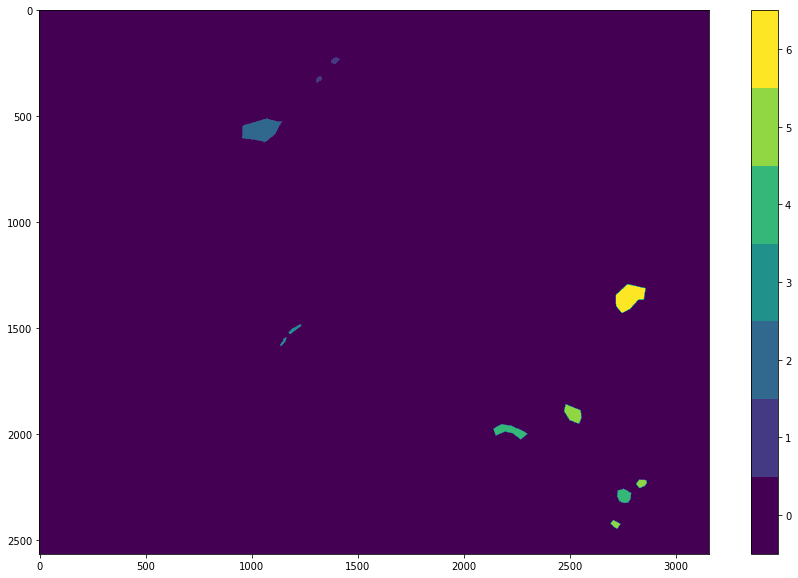

In [495]:
n_classes = np.unique(eop_salo.mask_timeless['20210420_salo']).size
cmap=discrete_cmap(n_classes, 'viridis')
plt.figure(figsize=(15, 10))
plt.imshow(eop_salo.mask_timeless['20210420_salo'].squeeze(), cmap=cmap)
cbar = plt.colorbar(ticks=range(n_classes))
plt.clim(-0.5, n_classes - 0.5)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4', '5', '6']);  # vertically oriented colorbar

In [496]:
n_classes

7

#### Import geotiffs

In [497]:
gtiff_lst = ['/home/AOIs/polyphytos/young_research_data/sen2cor/from_miscellaneous/salo/RT_Subset_S2A_MSIL2A_20210420T100021_N0300_R122_T34VEM_20210420T114413_resampled.tif']
gtiff_lst = [Path(i) for i in gtiff_lst]

# Import all Sentinel-2 geotiffs
for idx, path in enumerate(gtiff_lst):
    
    # Read flood geotiff
    eop_task = ImportFromTiff(feature=(FeatureType.DATA, re.findall(r'_([0-9]{8})T[0-9]{6}_', path.stem)[0] + '_salo'),
                           folder=str(path),
                           no_data_value=0)
    
    eop_salo = eop_salo.merge(eop_task.execute())

eop_salo

EOPatch(
  data: {
    20210420_salo: numpy.ndarray(shape=(1, 2564, 3158, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20210420_salo: numpy.ndarray(shape=(2564, 3158, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_salo: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=11, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: []
)

In [498]:
# derive only the pixels that fall on the mask
fname = '20210420_salo'
for feat_name in [('muddy_coast_north', 1), ('muddy_coast_north_cloud', 2), ('muddy_coast_middle', 3), ('muddy_coast_southeast', 4),
                  ('muddy_coast_southeast_cloud', 5), ('muddy_coast_southeast_many_cloud', 6)]:
    eop_salo.scalar[feat_name[0]] = eop_salo.data[fname].squeeze()[eop_salo.mask_timeless[fname].squeeze()==feat_name[1], :]

eop_salo

EOPatch(
  data: {
    20210420_salo: numpy.ndarray(shape=(1, 2564, 3158, 10), dtype=float32)
  }
  mask: {}
  scalar: {
    muddy_coast_middle: numpy.ndarray(shape=(1303, 10), dtype=float32)
    muddy_coast_north: numpy.ndarray(shape=(1482, 10), dtype=float32)
    muddy_coast_north_cloud: numpy.ndarray(shape=(13964, 10), dtype=float32)
    muddy_coast_southeast: numpy.ndarray(shape=(8698, 10), dtype=float32)
    muddy_coast_southeast_cloud: numpy.ndarray(shape=(7183, 10), dtype=float32)
    muddy_coast_southeast_many_cloud: numpy.ndarray(shape=(12089, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20210420_salo: numpy.ndarray(shape=(2564, 3158, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20210420_salo: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=11, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((576270.0, 6673780.0), (607850.0, 6699420.0)), crs=CRS('32634'))
  timestamp: []
)

In [499]:
# bidx = 2
# fig, ax = plt.subplots(figsize=(15, 8))
# plt.hist(eop_salo.scalar['muddy_coast_north'][:, bidx], bins=25);
# plt.hist(eop_salo.scalar['muddy_coast_north_cloud'][:, bidx], bins=25);
# plt.hist(eop_salo.scalar['muddy_coast_middle'][:, bidx], bins=25);
# plt.hist(eop_salo.scalar['muddy_coast_southeast'][:, bidx], bins=25);
# plt.hist(eop_salo.scalar['muddy_coast_southeast_cloud'][:, bidx], bins=25, alpha=0.6);
# plt.hist(eop_salo.scalar['muddy_coast_southeast_many_cloud'][:, bidx], bins=25, alpha=0.55);
# plt.title(f'{b_names[bidx]} - {b_alias[bidx]}', fontsize=20)
# plt.xlabel('DN', fontsize=15)
# plt.ylabel('# Observations', fontsize=15);
# plt.legend(['muddy coast north', 'muddy coast north cloud', 'muddy coast middle',
#             'muddy coast southeast', 'muddy coast southeast cloud', 'muddy coast southeast many cloud'], fontsize=15);

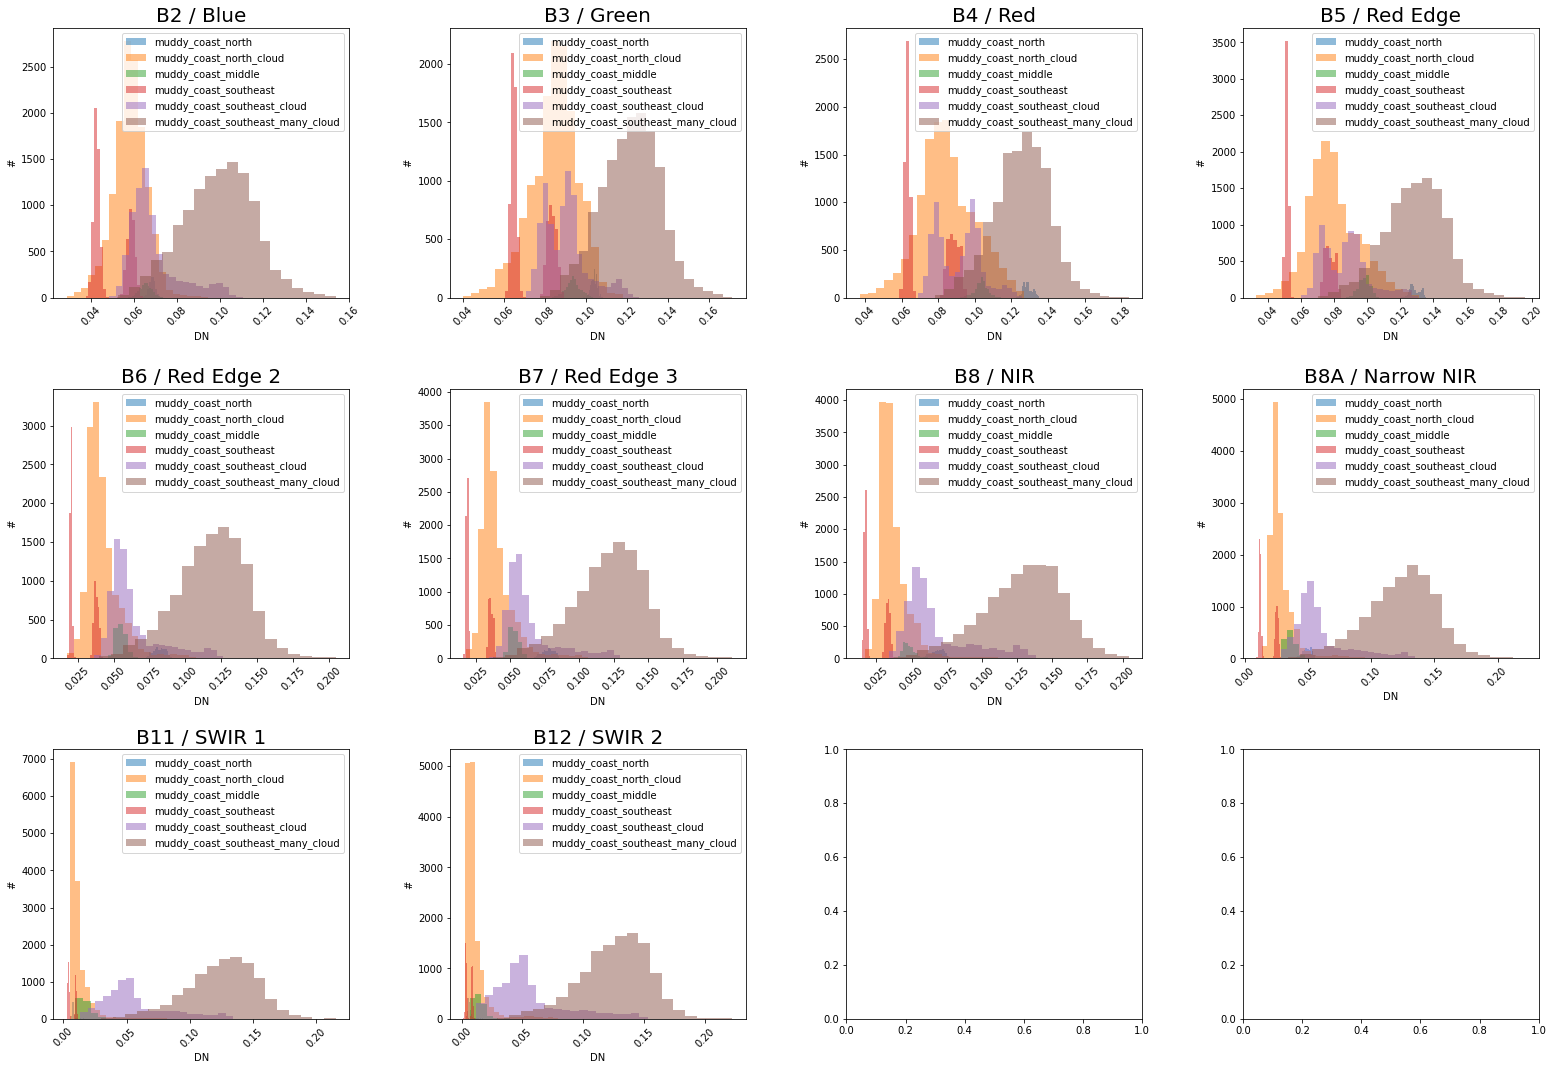

In [500]:
fig, axes = plt.subplots(figsize=(23, 16), ncols=4, nrows=3)
fig.tight_layout(pad=7.0)
data_keys = eop_salo.scalar.keys()

# Plot histograms
for fname in data_keys:
    
    for bidx in range(len(b_cwave)):
        
        ax = axes.ravel()[bidx]
        ax.hist(eop_salo.scalar[fname][:, bidx], bins=20, alpha=0.5);
        ax.set_title(f'{b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
        ax.tick_params('x', rotation=45)
        ax.set_xlabel('DN')
        ax.set_ylabel('#')
        ax.legend(data_keys, fontsize=10, loc='best');

Spectral signatures

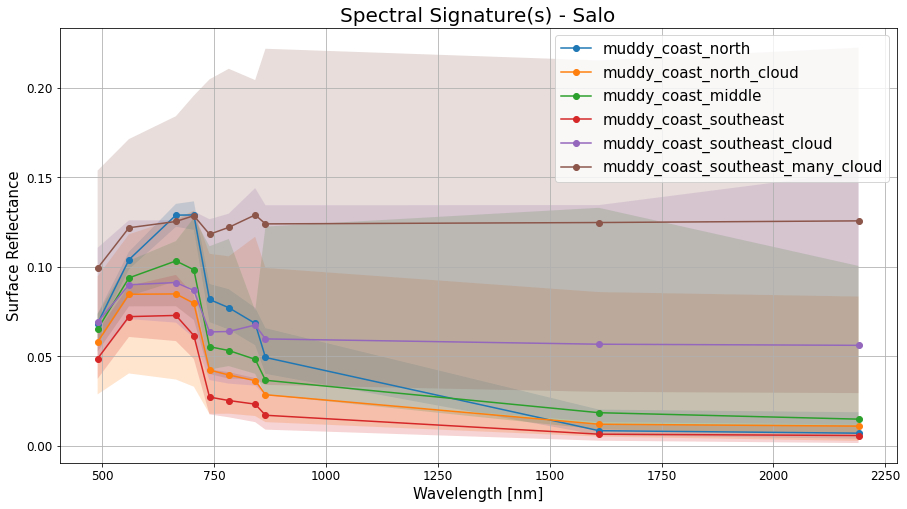

In [501]:
fig, ax = plt.subplots(figsize=(15, 8))

for fname in data_keys:
    
    bmean, bmin, bmax = get_spectral_mean_min_max(eop_salo.scalar[fname])
    
    ax.fill_between(b_cwave, bmax, bmin, alpha=0.2); # plot confidence intervals
    ax.plot(b_cwave, bmean, '-o'); # plot mean
    
ax.legend(data_keys, fontsize=15);
ax.set_title('Spectral Signature(s) - Salo', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();

### Prokopos

In [502]:
prokopos_shp = list(base_path.glob('*prokopos.shp'))
prokopos_shp

[PosixPath('/home/AOIs/polyphytos/young_research_data/sen2cor/spectral_signature_exploration/sen2cor/samples/20211204_prokopos.shp')]

In [503]:
# Get polyphytos bbox
eop_tiff = ImportFromTiff(feature=(FeatureType.DATA, 'temp'),
                          folder='/home/AOIs/polyphytos/young_research_data/sen2cor/from_miscellaneous/prokopos/RT_Subset_S2A_MSIL2A_20211204T092351_N0301_R093_T34SEH_20211204T122202_resampled_prokopos.tif')
eop_tiff = eop_tiff.execute()
eop_tiff

EOPatch(
  data: {
    temp: numpy.ndarray(shape=(1, 2773, 2444, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: BBox(((524820.0, 4217290.0), (549260.0, 4245020.0)), crs=CRS('32634'))
  timestamp: []
)

#### Import vectors

In [504]:
# initialize eop
eop_prokopos = EOPatch()

# Import all vectors
for idx, path in enumerate(prokopos_shp):
    eop_task = VectorImportTask(feature=(FeatureType.VECTOR_TIMELESS, path.stem),
                                path=str(path),
                                reproject=True)

#     eop_task = eop_task.execute()
    eop_prokopos = eop_prokopos.merge(eop_task.execute(bbox=eop_tiff.bbox))

eop_prokopos

EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20211204_prokopos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=17, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((524820.0, 4217290.0), (549260.0, 4245020.0)), crs=CRS('32634'))
  timestamp: []
)

#### Vector to Raster

In [505]:
# Rasterize vector
for idx, path in enumerate(prokopos_shp):
    eop_task = VectorToRaster(vector_input=(FeatureType.VECTOR_TIMELESS, path.stem),
                         raster_feature=(FeatureType.MASK_TIMELESS, path.stem),
                         values=[1, 2, 3, 4],
                         values_column='class',
#                          no_data_value=no_data_value,
                         raster_dtype=np.uint8,
                         raster_resolution=(10, 10))

    eop_task.execute(eop_prokopos)

eop_prokopos

/usr/local/lib/python3.6/dist-packages/eolearn/geometry/transformations.py:173: RuntimeWarning: Given vector polygons contain some invalid geometries, they will be fixed
  warnings.warn('Given vector polygons contain some invalid geometries, they will be fixed', RuntimeWarning)


EOPatch(
  data: {}
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20211204_prokopos: numpy.ndarray(shape=(2773, 2444, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20211204_prokopos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=17, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((524820.0, 4217290.0), (549260.0, 4245020.0)), crs=CRS('32634'))
  timestamp: []
)

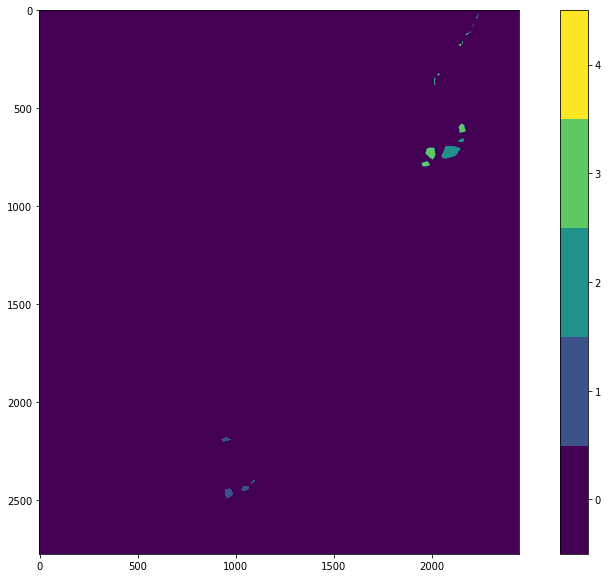

In [506]:
n_classes = np.unique(eop_prokopos.mask_timeless['20211204_prokopos']).size
cmap=discrete_cmap(n_classes, 'viridis')
plt.figure(figsize=(15, 10))
plt.imshow(eop_prokopos.mask_timeless['20211204_prokopos'].squeeze(), cmap=cmap)
cbar = plt.colorbar(ticks=range(n_classes))
plt.clim(-0.5, n_classes - 0.5)
cbar.ax.set_yticklabels(['0', '1', '2', '3', '4']);  # vertically oriented colorbar

In [507]:
n_classes

5

#### Import geotiffs

In [508]:
gtiff_lst = ['/home/AOIs/polyphytos/young_research_data/sen2cor/from_miscellaneous/prokopos/RT_Subset_S2A_MSIL2A_20211204T092351_N0301_R093_T34SEH_20211204T122202_resampled_prokopos.tif']
gtiff_lst = [Path(i) for i in gtiff_lst]

# Import all Sentinel-2 geotiffs
for idx, path in enumerate(gtiff_lst):
    
    # Read flood geotiff
    eop_task = ImportFromTiff(feature=(FeatureType.DATA, re.findall(r'_([0-9]{8})T[0-9]{6}_', path.stem)[0] + '_prokopos'),
                           folder=str(path),
                           no_data_value=0)
    
    eop_prokopos = eop_prokopos.merge(eop_task.execute())

eop_prokopos

EOPatch(
  data: {
    20211204_prokopos: numpy.ndarray(shape=(1, 2773, 2444, 10), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20211204_prokopos: numpy.ndarray(shape=(2773, 2444, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20211204_prokopos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=17, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((524820.0, 4217290.0), (549260.0, 4245020.0)), crs=CRS('32634'))
  timestamp: []
)

In [509]:
# derive only the pixels that fall on the mask
fname = '20211204_prokopos'
for feat_name in [('muddy_prokopos_lake', 1), ('muddy_coast_nexto_prokopos', 2), ('muddy_coast_nexto_prokopos_clouds', 3), ('muddy_river_nexto_prokopos_clouds', 4)]:
    eop_prokopos.scalar[feat_name[0]] = eop_prokopos.data[fname].squeeze()[eop_prokopos.mask_timeless[fname].squeeze()==feat_name[1], :]

eop_prokopos

EOPatch(
  data: {
    20211204_prokopos: numpy.ndarray(shape=(1, 2773, 2444, 10), dtype=float32)
  }
  mask: {}
  scalar: {
    muddy_coast_nexto_prokopos: numpy.ndarray(shape=(4694, 10), dtype=float32)
    muddy_coast_nexto_prokopos_clouds: numpy.ndarray(shape=(4096, 10), dtype=float32)
    muddy_prokopos_lake: numpy.ndarray(shape=(3316, 10), dtype=float32)
    muddy_river_nexto_prokopos_clouds: numpy.ndarray(shape=(490, 10), dtype=float32)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    20211204_prokopos: numpy.ndarray(shape=(2773, 2444, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {
    20211204_prokopos: geopandas.GeoDataFrame(columns=['class', 'geometry'], length=17, crs=EPSG:32634)
  }
  meta_info: {}
  bbox: BBox(((524820.0, 4217290.0), (549260.0, 4245020.0)), crs=CRS('32634'))
  timestamp: []
)

In [510]:
# bidx = 2
# fig, ax = plt.subplots(figsize=(15, 8))
# plt.hist(eop_prokopos.scalar['muddy_coast_nexto_prokopos'][:, bidx], bins=25);
# plt.hist(eop_prokopos.scalar['muddy_coast_nexto_prokopos_clouds'][:, bidx], bins=25);
# plt.hist(eop_prokopos.scalar['muddy_prokopos_lake'][:, bidx], bins=25);
# plt.hist(eop_prokopos.scalar['muddy_river_nexto_prokopos_clouds'][:, bidx], bins=25);
# plt.title(f'{b_names[bidx]} - {b_alias[bidx]}', fontsize=20)
# plt.xlabel('DN', fontsize=15)
# plt.ylabel('# Observations', fontsize=15);
# plt.legend(['muddy coast next to prokopos', 'muddy coast next to prokopos clouds', 'muddy prokopos lake',
#             'muddy river next to prokopos clouds'], fontsize=15);

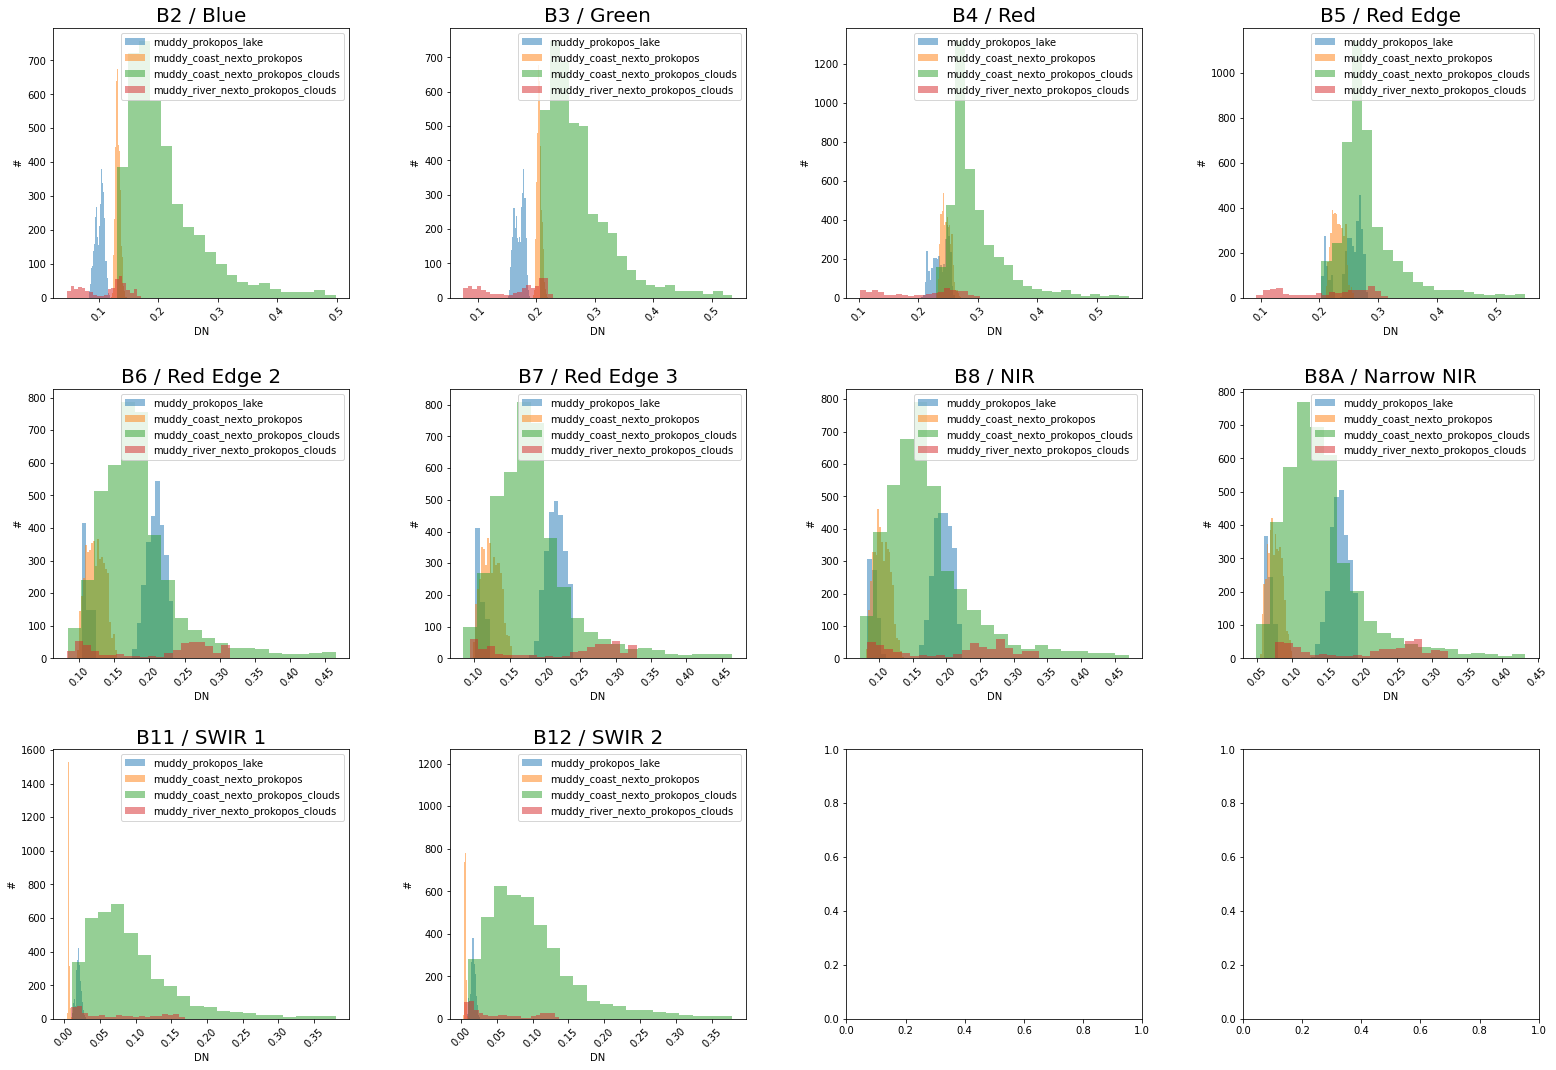

In [511]:
fig, axes = plt.subplots(figsize=(23, 16), ncols=4, nrows=3)
fig.tight_layout(pad=7.0)
data_keys = eop_prokopos.scalar.keys()

# Plot histograms
for fname in data_keys:
    
    for bidx in range(len(b_cwave)):
        
        ax = axes.ravel()[bidx]
        ax.hist(eop_prokopos.scalar[fname][:, bidx], bins=20, alpha=0.5);
        ax.set_title(f'{b_names[bidx]} / {b_alias[bidx]}', fontsize=20)
        ax.tick_params('x', rotation=45)
        ax.set_xlabel('DN')
        ax.set_ylabel('#')
        ax.legend(data_keys, fontsize=10, loc='best');

Spectral signatures

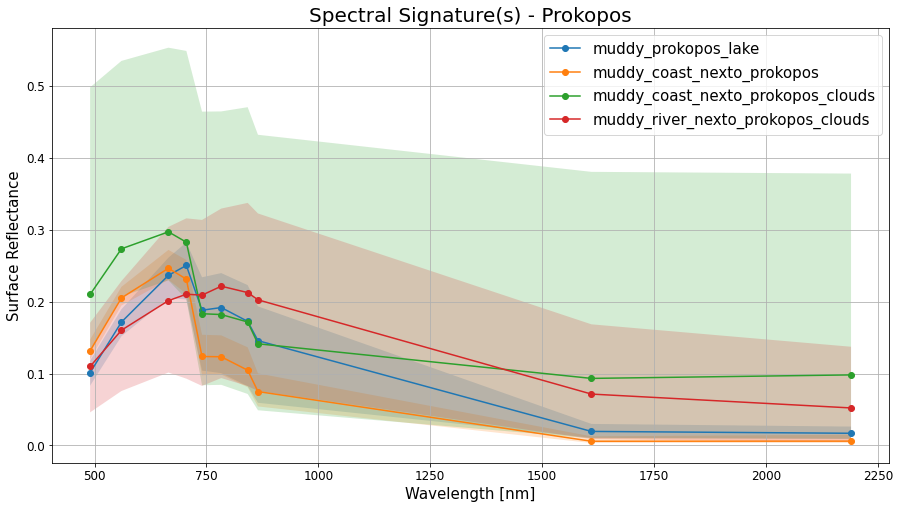

In [512]:
fig, ax = plt.subplots(figsize=(15, 8))

for fname in data_keys:
    
    bmean, bmin, bmax = get_spectral_mean_min_max(eop_prokopos.scalar[fname])
    
    ax.fill_between(b_cwave, bmax, bmin, alpha=0.2); # plot confidence intervals
    ax.plot(b_cwave, bmean, '-o'); # plot mean
    
ax.legend(data_keys, fontsize=15);
ax.set_title('Spectral Signature(s) - Prokopos', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();

### Spectral Signatures of all muddy water

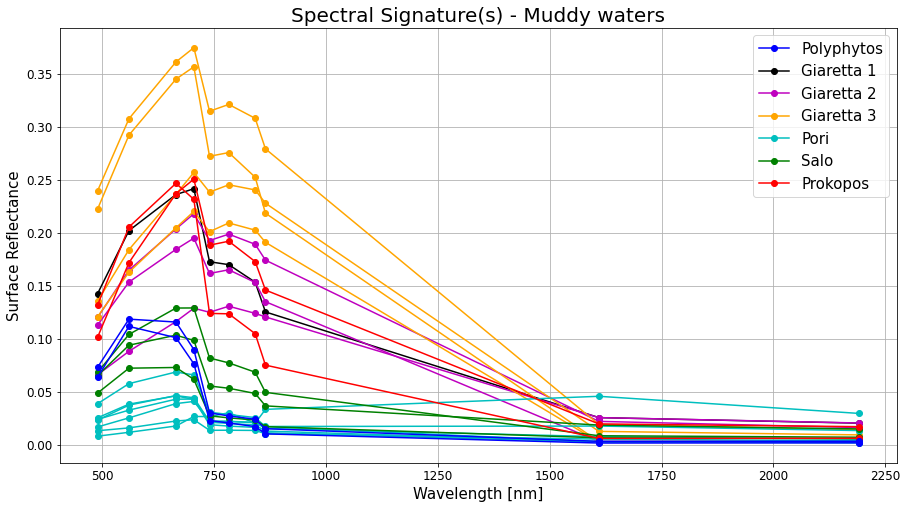

In [534]:
fig, ax = plt.subplots(figsize=(15, 8))

bmean_polyph_a, _, _ = get_spectral_mean_min_max(eop_polyph.scalar['20211219_polyphytos'])
bmean_polyph_b, _, _ = get_spectral_mean_min_max(eop_polyph.scalar['20211224_polyphytos'])

bmean_giaretta_1, _, _ = get_spectral_mean_min_max(eop_giaretta_1.scalar['20181031_giaretta'])

bmean_giaretta_2_a, _, _ = get_spectral_mean_min_max(eop_giaretta_2.scalar['muddy_coast'])
bmean_giaretta_2_b, _, _ = get_spectral_mean_min_max(eop_giaretta_2.scalar['muddy_river'])

bmean_giaretta_3_a, _, _ = get_spectral_mean_min_max(eop_giaretta_3.scalar['muddy_coast_left'])
bmean_giaretta_3_b, _, _ = get_spectral_mean_min_max(eop_giaretta_3.scalar['muddy_coast_right'])
bmean_giaretta_3_c, _, _ = get_spectral_mean_min_max(eop_giaretta_3.scalar['muddy_river_left'])
bmean_giaretta_3_d, _, _ = get_spectral_mean_min_max(eop_giaretta_3.scalar['muddy_river_right'])

bmean_pori_a, _, _ = get_spectral_mean_min_max(eop_pori.scalar['muddy_coast_mid_brown'])
bmean_pori_b, _, _ = get_spectral_mean_min_max(eop_pori.scalar['muddy_coast_dark_brown'])
bmean_pori_c, _, _ = get_spectral_mean_min_max(eop_pori.scalar['muddy_coast_very_dark_brown'])
bmean_pori_d, _, _ = get_spectral_mean_min_max(eop_pori.scalar['muddy_coast_light_brown'])
bmean_pori_e, _, _ = get_spectral_mean_min_max(eop_pori.scalar['muddy_coast_outlier_brown'])
bmean_pori_f, _, _ = get_spectral_mean_min_max(eop_pori.scalar['muddy_river_very_dark_brown'])
bmean_pori_g, _, _ = get_spectral_mean_min_max(eop_pori.scalar['muddy_river_dark_brown'])

bmean_salo_a, _, _ = get_spectral_mean_min_max(eop_salo.scalar['muddy_coast_north'])
bmean_salo_b, _, _ = get_spectral_mean_min_max(eop_salo.scalar['muddy_coast_middle'])
bmean_salo_c, _, _ = get_spectral_mean_min_max(eop_salo.scalar['muddy_coast_southeast'])

bmean_prokopos_a, _, _ = get_spectral_mean_min_max(eop_prokopos.scalar['muddy_prokopos_lake'])
bmean_prokopos_b, _, _ = get_spectral_mean_min_max(eop_prokopos.scalar['muddy_coast_nexto_prokopos'])


p2, = ax.plot(b_cwave, bmean_giaretta_1, '-ko'); # plot mean

p3, = ax.plot(b_cwave, bmean_giaretta_2_a, '-mo'); # plot mean
ax.plot(b_cwave, bmean_giaretta_2_b, '-mo'); # plot mean
ax.plot(b_cwave, bmean_giaretta_2_c, '-mo'); # plot mean

p4, = ax.plot(b_cwave, bmean_giaretta_3_a, '-go', color='orange'); # plot mean
ax.plot(b_cwave, bmean_giaretta_3_b, '-go', color='orange'); # plot mean
ax.plot(b_cwave, bmean_giaretta_3_c, '-go', color='orange'); # plot mean
ax.plot(b_cwave, bmean_giaretta_3_d, '-go', color='orange'); # plot mean

p5, = ax.plot(b_cwave, bmean_pori_a, '-co'); # plot mean
ax.plot(b_cwave, bmean_pori_b, '-co'); # plot mean
ax.plot(b_cwave, bmean_pori_c, '-co'); # plot mean
ax.plot(b_cwave, bmean_pori_d, '-co'); # plot mean
ax.plot(b_cwave, bmean_pori_e, '-co'); # plot mean
ax.plot(b_cwave, bmean_pori_f, '-co'); # plot mean
ax.plot(b_cwave, bmean_pori_g, '-co'); # plot mean

p6, = ax.plot(b_cwave, bmean_salo_a, '-o', color='green'); # plot mean
ax.plot(b_cwave, bmean_salo_b, '-o', color='green'); # plot mean
ax.plot(b_cwave, bmean_salo_c, '-o', color='green'); # plot mean

p7, = ax.plot(b_cwave, bmean_prokopos_a, '-ro'); # plot mean
ax.plot(b_cwave, bmean_prokopos_b, '-ro'); # plot mean

p1, = ax.plot(b_cwave, bmean_polyph_a, '-bo'); # plot mean
ax.plot(b_cwave, bmean_polyph_b, '-bo'); # plot mean

ax.legend([p1, p2, p3, p4, p5, p6, p7], ['Polyphytos', 'Giaretta 1', 'Giaretta 2', 'Giaretta 3', 'Pori', 'Salo', 'Prokopos'], fontsize=15);
ax.set_title('Spectral Signature(s) - Muddy waters', fontsize=20)
ax.set_ylabel('Surface Reflectance', fontsize=15)
ax.set_xlabel('Wavelength [nm]', fontsize=15)
ax.tick_params('both', labelsize=12)
ax.grid();